# Experiment of SRT using Binomial synthetic data with B = 16.

## Packages

In [ ]:
%pylab inline
from collections import Counter, defaultdict
from scipy.stats import bernoulli
from scipy.stats import binom
import numpy as np

import multiprocessing

import torch
import torch.multiprocessing as mp

import matplotlib.pyplot as plt
import math
from sympy import symbols, Eq, solve, exp, log

Populating the interactive namespace from numpy and matplotlib


##Sample Randomize and Threshold (SRT)

### Algorithm


#### SRT v1

In [ ]:
#Estimation of SRT with correction

def SRT_v1(X, B, t0, t1, ps, tau):
    n = len(X)
    elements = []
    for el in range(1, B+1):
        elements.append(el)

    #Calculating true count
    cx = Counter(X)

    #Calculating true relative frequency
    phix = defaultdict(int)
    for k in cx.keys():
        phix[k] = cx[k] / n

    #Randomization
    X_rand = []
    for x in X:
        ex = [0] * (B+1)
        ex[x] = 1
        for i in range(1, len(ex)):
            if ex[i] == 1:
                ex[i] = bernoulli.rvs(t1)
            else:
                ex[i] = bernoulli.rvs(t0)
        for i in range(len(ex)):
            if ex[i] == 1:
                X_rand.append(i)

    #Sampling (the implementation is different)
    sample = []
    for a in X_rand:
        rv = bernoulli.rvs(ps)
        if rv:
            sample.append(a)
    calg = Counter(sample)

    #Thresholding
    for k in calg.keys():
        if calg[k] < tau:
            calg[k] = 0
        # correction
        if calg[k] > 0:
            calg[k] = int ((calg[k] - n * ps * t0) / (ps * (t1-t0)) )

    #Calculating estimated relative frequency (with the total size = total nonzer counts)
    phialg = defaultdict(int)
    total_app = sum(list(calg.values()))
    for k in calg.keys():
        phialg[k] = calg[k] / total_app

    return cx, phix, calg, phialg

#### SRTv2

In [ ]:
import torch
from collections import Counter, defaultdict

def encode_and_randomize(x, B, t0, t1, device):
    # Create tensors directly on the appropriate device
    one_hot_vector = torch.zeros(B+1, device=device)
    one_hot_vector[x] = 1
    encoded_vector = torch.where(one_hot_vector == 0,
                                 torch.bernoulli(torch.full((B+1,), float(t0), device=device)),
                                 torch.bernoulli(torch.full((B+1,), float(t1), device=device)))
    return encoded_vector

def SRT_v2(X, B, t0, t1, ps, tau, device='cuda'):

    n = len(X)

    # Calculating true count
    cx = Counter(X)

    # Calculating true relative frequency
    phix = {k: v / n for k, v in cx.items()}

    matrix2 = torch.empty((n, B+1), device=device)

    for i, x in enumerate(X):
        encoded_vector = encode_and_randomize(x, B, t0, t1, device)
        matrix2[i] = encoded_vector

    matrix1 = torch.bernoulli(torch.full((1, n), float(ps), device=device))
    result = torch.matmul(matrix1, matrix2)

    X_rand = result.cpu().tolist()
    calg = X_rand[0]

    # Thresholding
    for k in range(len(calg)):
        calg[k] = int((calg[k] - n * ps * t0) / (ps * (t1 - t0)))
        if calg[k] < tau:
            calg[k] = 0

    # Calculating estimated relative frequency (with the total size = total non-zero counts)
    total_app = sum(calg)
    phialg = {k: calg[k] / total_app for k in range(B)}

    return cx, phix, calg, phialg

### Parameter tuning (Randomization mechanism)

In [ ]:

#algorithm
#SRT parameter tuning
def solve_system_SRT(n, tau, epsilon, delta):
    A = ((log(1/delta) / (2 * n))**(1/2)).evalf()
    t_1 = 1/2

    #x = p
    #y = t0
    # Define the symbols
    x, y = symbols('x y', real=True, nonnegative=True)

    # Define the equations
    equation_1 = Eq((n - tau) * x**2 * y**2 + ((tau + 1 - n) / 2) * x**2 * y + (exp(-2 * epsilon) - 1) * tau * x * y - (tau / 4) * x**2 + (1 - exp(-2 * epsilon)) * (tau / 2) * x + (1 - exp(-2 * epsilon)) * A * n, 0)
    equation_2 = Eq(exp(-epsilon) * x * y - (1 / 2) * x + 1 - exp(-epsilon), 0)

    # Solve the system of equations for x and y
    solutions = solve((equation_1, equation_2), (x, y))

    #print("All solutions:(p, t0)=", solutions)

    #Find the solution with p and smaller t0
    #print(f"Number of solutions = {len(solutions)}")
    solutions.sort(key = lambda x:x[0])
    sol = solutions[0]
    #print(f"The solution is p={sol[0]}, t_0={sol[1]}")

    #verifying if y is also the minimum when x is the minimum
    y_solutions = [s[1] for s in solutions]
    y_solutions.sort()
    if y_solutions[0] < sol[1]:
      print(f"Warning:the solution does not have the minimum t_0")

    if sol[0] < 1:
      ep_0 = log((1-sol[1]) / sol[1])
      return sol[0], sol[1], ep_0

    x, y, ep_0 = solve_system_SRT(n, tau, 0.5, delta)
    print(f"epsilon = 0.5")
    return x, y, ep_0

"""
    if sol[0] > 0.5:
      print(f"Warning:p={sol[0]} > 0.5")
      sol = (0.5, sol[1])
      print(f"The solution is p={sol[0]}, t_0={sol[1]}")
      ep_new, del_new = calculate_epsilon_delta(sol[1], t_1, sol[0], tau, n)
      if ep_new <= epsilon and del_new <= delta:
        print("OK")
      else:
        print("NOT OK")
        print(f"ep_new = {ep_new:.3f}")
        print(f"del_new = {del_new:.3f}")

    if sol[1] > 0.5:
      print(f"Warning:p={sol[1]} > 0.5")
      sol = (0.5, sol[1])
      print(f"The solution is p={sol[0]}, t_0={sol[1]}")
      ep_new, del_new = calculate_epsilon_delta(sol[1], t_1, sol[0], tau, n)
      if ep_new <= epsilon and del_new <= delta:
        print("OK")
      else:
        print("NOT OK")
        print(f"ep_new = {ep_new:.3f}")
        print(f"del_new = {del_new:.3f}")

    ep_0 = log((1-sol[1]) / sol[1])
    print(f"ep_0 = {ep_0:.3f}")
"""

def calculate_epsilon_delta(t_0, t_1, p, tau, n):
    # Calculating q
    q = (1 - p * t_1) / (1 - p * t_0)

    # Calculating denominator
    D = (1-q**2 + p * (t_0 - t_1))*(t_1 - t_0)

    # Calculating alpha from tau
    alpha = (D * tau / (n*t_0) + 1) / (1-q**2) -1

    # Calculating epsilon
    epsilon = math.log(1 / q)

    # Calculating delta
    #print(-2 * n * alpha**2 * p**2 * t_0**2)
    delta = (math.exp(-2 * n * alpha**2 * p**2 * t_0**2) )

    return epsilon, delta

In [ ]:
"""
n_value = 10**5
epsilon_value = 0.1
delta_value = 10**(-6)

Epsilons_value = [0.1, 0.5, 1]
tau_value = 100

for ep in Epsilons_value:
  p, t0, ep_0 = solve_system_SRT(n_value, tau_value, ep, delta_value * 0.5)
  print(f"p = {p:.3f}, t_0 = {t0:.3f}, ep_0 = {ep_0:.3f}")

  #verification
  epsilon_verify, delta_verify = calculate_epsilon_delta(t0, 1/2, p, tau_value, n_value)
  print(f"epsilon = {epsilon_verify:.3f}, delta = {delta_verify}")
"""

'\nn_value = 10**5\nepsilon_value = 0.1\ndelta_value = 10**(-6)\n\nEpsilons_value = [0.1, 0.5, 1]\ntau_value = 100\n\nfor ep in Epsilons_value:\n  p, t0, ep_0 = solve_system_SRT(n_value, tau_value, ep, delta_value * 0.5)\n  print(f"p = {p:.3f}, t_0 = {t0:.3f}, ep_0 = {ep_0:.3f}")\n\n  #verification\n  epsilon_verify, delta_verify = calculate_epsilon_delta(t0, 1/2, p, tau_value, n_value)\n  print(f"epsilon = {epsilon_verify:.3f}, delta = {delta_verify}")\n'

In [ ]:

def OUE(eps, delta, n, eps_0, tune_p = False, optional_p = 1):
    t1 = 1/2
    t0 = 1/(np.exp(eps_0 / 2) + 1)

    p = (np.exp(eps) - 1) / (np.exp(eps) * t1 - t0)
    if p > 1:
      p = min(p, 1)
      print("Warning: p > 1, the privacy guarantee eps will be smaller than the assigned.")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )
    if tune_p:
      p = min([p, optional_p])
      print("Warning: p is tuned. ")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )

    q = (1-p*t1) / (1 - p*t0)
    eta = (1 - q**2) - p*t1 + p*t0
    alpha = np.sqrt( np.log(delta) / (-2 * n * p**2 * t0**2))
    tau = ( (1 + alpha) * (1 - q**2) * n * p * t0 / eta - n * t0 ) / (t1 - t0)
    return t1, t0, float(p), tau


In [ ]:
def DE(eps, delta, n, eps_0, B, tune_p = False, optional_p = 1):
    t1 = np.exp(eps_0) / (np.exp(eps_0) + B - 1)
    t0 = 1 / (np.exp(eps_0) + B - 1)

    p = (np.exp(eps) - 1) / (np.exp(eps) * t1 - t0)
    if p > 1:
      p = min(p, 1)
      print("Warning: p > 1, the privacy guarantee eps will be smaller than the assigned.")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )
    if tune_p:
      p = min([p, optional_p])
      print("Warning: p is tuned. ")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )

    q = (1-p*t1) / (1 - p*t0)
    eta = (1 - q**2) - p*t1 + p*t0
    alpha = np.sqrt( np.log(delta) / (-2 * n * p**2 * t0**2))
    tau = (1 + alpha) * (1 - q**2) * n * p * t0 / eta
    return t1, t0, p, tau

In [ ]:
def SYM(eps, delta, n, eps_0, tune_p = False, optional_p = 1):
    t1 = np.exp(eps_0 / 2) / (np.exp(eps_0 / 2) + 1)
    t0 = 1 / (np.exp(eps_0 / 2) + 1)

    p = (np.exp(eps) - 1) / (np.exp(eps) * t1 - t0)
    if p > 1:
      p = min(p, 1)
      print("Warning: p > 1, the privacy guarantee eps will be smaller than the assigned.")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )
    if tune_p:
      p = min([p, optional_p])
      print("Warning: p is tuned. ")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )


    q = (1-p*t1) / (1 - p*t0)
    eta = (1 - q**2) - p*t1 + p*t0
    alpha = np.sqrt( np.log(delta) / (-2 * n * p**2 * t0**2))
    tau = (1 + alpha) * (1 - q**2) * n * p * t0 / eta
    return t1, t0, p, tau

## Sample and Threshold (ST)

###Algorithm

In [ ]:
#Estimation of ST with correction

def ST_sim(X, B, ps, tau):
    n = len(X)

    #counting true frequency
    cx = Counter(X)

    #obtaining true relative frequency
    phix = defaultdict(int)
    for k in cx.keys():
        phix[k] = cx[k] / n

    #sampling
    sample = []
    for a in X:
        rv = bernoulli.rvs(ps)
        if rv:
            sample.append(a)
    calg = Counter(sample)

    calg[k] = int(calg[k] / ps)  # correction
    #tau_corrected = tau / ps
    #thresholding
    for k in calg.keys():
        if calg[k] < tau:
            calg[k] = 0

    #obtaining estimated relative frequency
    phialg = defaultdict(int)
    total_app = sum(list(calg.values()))
    for k in calg.keys():
        phialg[k] = calg[k] / total_app

    return cx, phix, calg, phialg

#cx = true count
#phix = true relative frequency
#calg = estimated count after ST
#phialg = estimated relative frequency

### Parameter Tuning

In [ ]:
def st_param(eps, delta, alpha = 0.2):
    if eps > 1:
      print("Warning of ST: eps is not allowed")
    ps = alpha * (1 - np.exp(-eps))
    Calp = np.log(1/alpha) - 1/(1+alpha)
    if Calp < 0:
      print("Warning of ST: C_alpha < 0")
    tau = 1 / Calp * np.log(1 / delta)
    return ps, tau / ps

##Unary Encoding (UE)

###Algorithm

In [ ]:
#Algorithm of unary encoding

import torch
from collections import Counter, defaultdict

def encode_and_randomize(x, B, t0, t1, device):
    # Create tensors directly on the appropriate device
    one_hot_vector = torch.zeros(B+1, device=device)
    one_hot_vector[x] = 1
    encoded_vector = torch.where(one_hot_vector == 0,
                                 torch.bernoulli(torch.full((B+1,), float(t0), device=device)),
                                 torch.bernoulli(torch.full((B+1,), float(t1), device=device)))
    return encoded_vector

def UE(X, B, t0, t1, ps, tau, device='cuda'):
    n = len(X)

    # Calculating true count
    cx = Counter(X)

    # Calculating true relative frequency
    phix = {k: v / n for k, v in cx.items()}

    matrix2 = torch.empty((n, B+1), device=device)

    for i, x in enumerate(X):
        encoded_vector = encode_and_randomize(x, B, t0, t1, device)
        matrix2[i] = encoded_vector

    matrix1 = torch.bernoulli(torch.full((1, n), 1.0, device=device))
    result = torch.matmul(matrix1, matrix2)

    X_rand = result.cpu().tolist()
    calg = X_rand[0]

    # Thresholding
    for k in range(len(calg)):
        calg[k] = int((calg[k] - n * 1 * t0) / (1 * (t1 - t0)))


    # Calculating estimated relative frequency (with the total size = total non-zero counts)
    total_app = sum(calg)
    phialg = {k: calg[k] / total_app for k in range(B)}

    return cx, phix, calg, phialg

def UE_raw(X, B, t0, t1, ps, tau, device='cuda'):

    n = len(X)

    # Calculating true count
    cx = Counter(X)

    # Calculating true relative frequency
    phix = {k: v / n for k, v in cx.items()}

    matrix2 = torch.empty((n, B+1), device=device)

    for i, x in enumerate(X):
        encoded_vector = encode_and_randomize(x, B, t0, t1, device)
        matrix2[i] = encoded_vector

    matrix1 = torch.bernoulli(torch.full((1, n), 1.0, device=device))
    result = torch.matmul(matrix1, matrix2)

    X_rand = result.cpu().tolist()
    calg = X_rand[0]


    # Calculating estimated relative frequency (with the total size = total non-zero counts)
    total_app = sum(calg)
    phialg = {k: calg[k] / total_app for k in range(B)}

    return cx, phix, calg, phialg

###Parameter Tuning

In [ ]:
#Parameter Tuning of Unary Encoding

def ue_param(eps):
  t1 = 1/2
  t0 = 1/(np.exp(eps)+1)
  return t1, t0

## Exp. 1 $B = 2^{4}$.

### Implementation

In [ ]:
#Comparing top k elements
#Index 0 is ST
#Index 1 is UE
#Index 2 is SRT

Eps = [0.1, 0.5, 1]
Trials = 10

k = 5

delta = 1e-6
B = 2**4
n = 10**5

#storing data
Dataset = []

#define max errors
Err0_max = []
Err1_max = []
Err2_max = []

#define min errors
Err0_avg = []
Err1_avg = []
Err2_avg = []

#Checking GPU
if torch.cuda.is_available():
    device = "cuda"
    print("GPU is available")
else:
    device = "cpu"
    print("GPU is unavailable")

for epsilon in Eps:

  #Tuning ST parameters
  p_st, tau_st = st_param(epsilon, delta, alpha = 1/6)
  print( f"ST parameters: p = {p_st}, tau = {tau_st}" )

  #Tuning UE parameters
  t1_ue, t0_ue = ue_param(epsilon)
  print( f"UE parameters: t1 = {t1_ue}, t0 = {t0_ue}" )

  #Tuning SRT parameters
  #eps_0 = 10
 # optional_p = 0.5
  tau_srt = 100.0
  t1 = 0.5
  p_srt, t0, ep0 = solve_system_SRT(n, tau_srt, epsilon / 2, delta / 2)
  print(p_srt, t0, ep0)

  print( f"SRT parameters: t1 = {t1}, t0 = {t0}, p_srt = {p_srt}, tau = {tau_srt}, ep0 = {ep0}" )

  #define max errors
  Err0_max_temp = []
  Err1_max_temp = []
  Err2_max_temp = []

  #define min errors
  Err0_avg_temp = []
  Err1_avg_temp = []
  Err2_avg_temp = []

  for trials in range(Trials):

      #Creating random binomial samples
      X = binom.rvs(n = B, p=0.4, size=n)

      #Implementing ST
      cx0, phix0, calg0, phialg0 = SRT_v2( X, B, 0.0, 1.0, p_st, tau_st, device )
      print("ST works")

      #Implementing UE
      cx1, phix1, calg1, phialg1 = UE( X, B, t0_ue, t1_ue, 1.0, 0.0, device )
      print("UE works")

      #Implementing SRT
      #SRT_v2(X, B, t0, t1, ps, tau, device='cuda')
      cx2, phix2, calg2, phialg2 = SRT_v2( X, B, t0, t1, p_srt, tau_srt, device )
      print("SRT works")

      if trials == 0:
        for i in range(B):
          if cx0[i] != cx2[i]:
            print("Error: real data does not match.")

      #storing data
      Dataset.append( [cx0, calg0, calg1, calg2] )

      #Measuring errors
      err0 = []
      err1 = []
      err2 = []
      k_frequent = cx0.most_common(k)

      for i in range(len(k_frequent)):
          entry = k_frequent[i][0]
          err0.append( abs( cx0[entry] - calg0[entry] ) / n )
          err1.append( abs( cx0[entry] - calg1[entry] ) / n )
          err2.append( abs( cx0[entry] - calg2[entry] ) / n )

      if len(err0) == 0:
          err0.append(0)
      if len(err1) == 0:
          err1.append(0)
      if len(err2) == 0:
          err2.append(0)

      Err0_max_temp.append(max(err0))
      Err1_max_temp.append(max(err1))
      Err2_max_temp.append(max(err2))

      Err0_avg_temp.append(mean(err0))
      Err1_avg_temp.append(mean(err1))
      Err2_avg_temp.append(mean(err2))

      #print("checkpoint: trials =  ", trials)

  Err0_max.append( mean(Err0_max_temp) )
  Err1_max.append( mean(Err1_max_temp) )
  Err2_max.append( mean(Err2_max_temp) )

  Err0_avg.append( mean(Err0_avg_temp) )
  Err1_avg.append( mean(Err1_avg_temp) )
  Err2_avg.append( mean(Err2_avg_temp) )

  print("checkpoint: epsilon =  ", epsilon)

GPU is available
ST parameters: p = 0.01586043032734008, tau = 932.0055029135224
UE parameters: t1 = 0.5, t0 = 0.47502081252106
0.129749439592488 0.130480882880368 1.89671359519553
SRT parameters: t1 = 0.5, t0 = 0.130480882880368, p_srt = 0.129749439592488, tau = 100.0, ep0 = 1.89671359519553
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
checkpoint: epsilon =   0.1
ST parameters: p = 0.06557822338122776, tau = 225.4103204004903
UE parameters: t1 = 0.5, t0 = 0.3775406687981454
0.466617542954436 0.0333227416327919 3.36762458836784
SRT parameters: t1 = 0.5, t0 = 0.0333227416327919, p_srt = 0.466617542954436, tau = 100.0, ep0 = 3.36762458836784
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST wo

### Printing Data

In [ ]:
print("Err0_max = ", Err0_max)
print("Err1_max = ", Err1_max)
print("Err2_max = ", Err2_max)
print("Err0_avg = ", Err0_avg)
print("Err1_avg = ", Err1_avg)
print("Err2_avg = ", Err2_avg)
print("Dataset = ", Dataset)

Err0_max =  [0.013380999999999999, 0.006487, 0.005466]
Err1_max =  [0.090527, 0.020224, 0.010735]
Err2_max =  [0.017107999999999998, 0.003972000000000001, 0.0028729999999999997]
Err0_avg =  [0.0077621999999999995, 0.0031106000000000003, 0.002844]
Err1_avg =  [0.0444622, 0.0098246, 0.006397]
Err2_avg =  [0.0088184, 0.0017666000000000001, 0.001347]
Dataset =  [[Counter({6: 19912, 7: 18874, 5: 16262, 8: 13994, 4: 10381, 9: 8290, 3: 4645, 10: 3943, 2: 1449, 11: 1427, 12: 420, 1: 282, 13: 78, 0: 33, 14: 9, 15: 1}), [0, 0, 1387, 4665, 10970, 14375, 21689, 20554, 14060, 9268, 4035, 1702, 0, 0, 0, 0, 0], [7643, 8483, 12887, 6281, 8283, 11166, 15289, 13848, -6168, 9124, 2438, -9331, -10091, 477, -6648, -5968, 837], [438, 292, 1981, 5610, 9198, 18271, 19376, 20711, 14371, 10366, 3379, 1627, 1230, 1084, 417, 167, 1418]], [Counter({6: 19678, 7: 19010, 5: 16050, 8: 14127, 4: 10206, 9: 8507, 3: 4667, 10: 3964, 11: 1476, 2: 1468, 12: 398, 1: 320, 13: 88, 0: 27, 14: 14}), [0, 0, 1450, 6115, 10907, 155

#### Input data

In [ ]:
Err0_max =  [0.016944749999999998, 0.007637250000000001, 0.00586075]
Err1_max =  [0.101573, 0.01833875, 0.00874375]
Err2_max =  [0.00887325, 0.002742, 0.0025165]
Err0_avg =  [0.0082853, 0.00384875, 0.00290905]
Err1_avg =  [0.0536842, 0.0092057, 0.004685]
Err2_avg =  [0.00444805, 0.00147275, 0.00127325]
Dataset =  [[Counter({6: 19797, 7: 19078, 5: 15985, 8: 14224, 4: 10055, 9: 8465, 3: 4768, 10: 3915, 11: 1460, 2: 1389, 12: 409, 1: 323, 13: 90, 0: 24, 14: 18}), [0, 0, 1387, 4287, 10403, 16140, 18851, 19104, 14438, 9331, 4035, 1387, 0, 0, 0, 0, 0], [-2325, 6922, 2358, 12367, 4040, 16250, 15329, 21254, 8483, -3406, 7803, -4527, 76, -11733, -10692, 5241, 1397], [106, 971, 1184, 5179, 10338, 16116, 20058, 18765, 14044, 8234, 3267, 1035, 1131, 469, 0, 0, 298]], [Counter({6: 19771, 7: 19011, 5: 16278, 8: 14199, 4: 9974, 9: 8471, 3: 4671, 10: 3886, 2: 1443, 11: 1409, 12: 426, 1: 332, 13: 83, 0: 28, 14: 16, 15: 2}), [0, 0, 1260, 5296, 10277, 15888, 19167, 20302, 12988, 8826, 3404, 1134, 0, 0, 0, 0, 0], [-8450, -4607, -203, 2959, 12687, 11286, 28900, 21134, 9284, 24417, 2879, -8610, -9090, -13294, -5888, 957, -7649], [0, 0, 1548, 5147, 10327, 16779, 19513, 18925, 13799, 7978, 4656, 1334, 362, 0, 0, 0, 138]], [Counter({6: 19727, 7: 19019, 5: 16185, 8: 14406, 4: 10088, 9: 8258, 3: 4683, 10: 3942, 2: 1485, 11: 1410, 12: 389, 1: 277, 13: 85, 0: 30, 14: 15, 15: 1}), [0, 0, 2458, 5422, 10655, 17653, 19167, 17969, 15005, 7376, 3404, 1891, 0, 0, 0, 0, 0], [1918, 6842, -1244, 5000, -403, 13768, 14889, 11246, 317, 11085, -5167, 11166, -3766, 3439, 5080, -6969, -11813], [116, 191, 1398, 5190, 10787, 15817, 20207, 19556, 13446, 8223, 4261, 992, 437, 0, 0, 0, 0]], [Counter({6: 19752, 7: 18915, 5: 16123, 8: 14419, 4: 10175, 9: 8260, 3: 4672, 10: 3948, 2: 1516, 11: 1433, 12: 381, 1: 267, 13: 100, 0: 27, 14: 11, 15: 1}), [0, 0, 1071, 3909, 10655, 16203, 19671, 19104, 13366, 7313, 4161, 1450, 0, 0, 0, 0, 0], [5681, -6288, 1117, 3199, 8163, 21814, 40470, 24977, 24377, 11606, 4880, -8650, 3079, -7969, -6448, 7482, -283], [351, 394, 1131, 4325, 9526, 16234, 18253, 19032, 13927, 7860, 3075, 1441, 789, 522, 447, 0, 0]], [Counter({6: 19882, 7: 18830, 5: 16128, 8: 14297, 4: 10189, 9: 8307, 3: 4670, 10: 3945, 2: 1567, 11: 1405, 12: 359, 1: 300, 13: 79, 0: 34, 14: 8}), [0, 0, 1639, 3909, 10781, 16077, 20175, 17023, 13240, 8953, 4539, 2143, 0, 0, 0, 0, 0], [7042, -683, -1884, 917, 4920, 6682, 17331, 22815, 16370, -1724, 4280, 7923, -723, -7129, -3245, -6929, 1918], [618, 405, 1238, 4357, 10167, 15946, 19331, 19641, 15123, 8106, 4271, 1558, 1644, 180, 0, 0, 148]], [Counter({6: 19760, 7: 18781, 5: 16216, 8: 14336, 4: 10142, 9: 8441, 3: 4692, 10: 3836, 2: 1530, 11: 1477, 12: 371, 1: 295, 13: 92, 0: 21, 14: 9, 15: 1}), [0, 0, 1765, 5233, 8637, 16456, 19104, 17338, 13429, 8890, 3846, 1197, 0, 0, 0, 0, 0], [1758, -4527, -723, 5361, 12166, 24977, 18211, 22455, 7843, 1317, -723, 2759, 4160, -11132, -9931, -2125, 1277], [159, 0, 1537, 5307, 10167, 16341, 18755, 19470, 13510, 8490, 3759, 1206, 0, 0, 0, 405, 0]], [Counter({6: 19880, 7: 19014, 5: 16227, 8: 14226, 4: 10037, 9: 8370, 3: 4633, 10: 3955, 2: 1534, 11: 1316, 12: 403, 1: 291, 13: 71, 0: 32, 14: 8, 15: 3}), [0, 0, 1576, 4476, 9394, 17212, 21247, 20175, 15636, 9016, 4161, 1324, 0, 0, 0, 0, 0], [1277, -803, 3960, 4760, 12767, 4720, 10645, 3559, 18772, 2919, 7643, 15569, 7563, 7482, -9371, 3920, 9844], [0, 266, 1783, 4592, 10018, 16287, 19257, 19299, 13382, 8159, 3887, 1580, 0, 0, 255, 415, 0]], [Counter({6: 19931, 7: 19111, 5: 16199, 8: 14081, 4: 10090, 9: 8350, 3: 4708, 10: 3929, 2: 1457, 11: 1388, 12: 396, 1: 258, 13: 78, 0: 15, 14: 7, 15: 2}), [0, 0, 1450, 5296, 9079, 15195, 19104, 19356, 16329, 8953, 3215, 1702, 0, 0, 0, 0, 0], [-2365, 3839, -8290, -1164, 10365, 15889, 27179, 14729, 20213, -323, 8403, -7209, -2365, 8323, -9811, 11326, 2919], [0, 223, 266, 4026, 10391, 15817, 19630, 18584, 14215, 8586, 3994, 992, 0, 0, 0, 202, 0]], [Counter({6: 19793, 7: 18960, 5: 16381, 8: 14188, 4: 10146, 9: 8289, 3: 4691, 10: 3838, 2: 1449, 11: 1429, 12: 406, 1: 297, 13: 89, 0: 31, 14: 11, 15: 2}), [0, 0, 1639, 5485, 10340, 16014, 20491, 18158, 15447, 8133, 2837, 1639, 0, 0, 0, 0, 0], [-7009, 6962, 6962, -8490, 18532, 9324, 15649, 10845, 17731, 4160, 1638, -10572, 7963, -11853, -14495, 6922, 5361], [0, 960, 2178, 5478, 10626, 15956, 20581, 20453, 14269, 8234, 3994, 1772, 0, 0, 0, 768, 982]], [Counter({6: 20009, 7: 18893, 5: 15998, 8: 14325, 4: 10253, 9: 8368, 3: 4679, 10: 3815, 2: 1439, 11: 1412, 12: 365, 1: 327, 13: 79, 0: 31, 14: 6, 15: 1}), [0, 0, 1450, 4854, 9457, 16140, 18914, 20112, 13114, 7692, 3719, 1324, 0, 0, 0, 0, 0], [8884, 1117, 6762, 6522, 15809, 8483, 13968, 11446, 20934, 11806, -2725, 4120, 6362, -4046, 317, -5407, -1164], [0, 0, 1761, 5254, 10562, 15508, 19449, 18413, 13030, 8715, 3780, 1783, 1056, 0, 0, 586, 0]], [Counter({6: 19649, 7: 19040, 5: 16218, 8: 14146, 4: 10004, 9: 8480, 3: 4658, 10: 4105, 2: 1491, 11: 1440, 12: 348, 1: 289, 13: 93, 0: 29, 14: 9, 15: 1}), [0, 0, 1071, 3846, 10340, 16708, 21436, 22004, 16014, 8448, 3846, 1387, 0, 0, 0, 0, 0], [-1724, 4240, 6882, 7362, -4607, 17331, 10805, 22095, 14168, 1117, 8724, -1284, 9925, -2325, -1164, -2765, -1884], [0, 0, 1270, 3887, 9740, 16362, 17964, 17430, 14450, 7721, 4090, 864, 533, 0, 0, 0, 0]], [Counter({6: 20086, 7: 18862, 5: 16052, 8: 14085, 4: 10139, 9: 8404, 3: 4732, 10: 3893, 2: 1520, 11: 1406, 12: 389, 1: 306, 13: 85, 0: 29, 14: 10, 15: 2}), [0, 0, 1513, 5043, 10403, 14375, 20932, 18599, 15005, 8953, 4476, 1513, 0, 0, 0, 0, 0], [1437, -2044, -3806, 10205, 13528, 24697, 16210, 17291, 5401, 14849, 8003, -4927, -243, -5487, -8370, -7569, -1244], [0, 1152, 1612, 5254, 10210, 15817, 19662, 19759, 14963, 7700, 3759, 1900, 0, 469, 0, 0, 0]], [Counter({6: 19947, 7: 18921, 5: 16088, 8: 14234, 4: 10280, 9: 8253, 3: 4668, 10: 3846, 2: 1512, 11: 1437, 12: 400, 1: 296, 13: 80, 0: 27, 14: 10, 15: 1}), [0, 0, 1828, 4350, 10781, 16140, 19167, 18410, 14186, 9205, 4098, 1387, 0, 0, 0, 0, 0], [3079, -10171, 2959, -1164, 15569, 11926, 14688, 18291, 18011, 17811, 16690, -4807, -763, 4040, 1998, 2959, 9684], [0, 608, 1078, 3780, 10306, 15614, 19609, 18990, 14098, 8330, 4357, 1708, 832, 0, 0, 0, 0]], [Counter({6: 19849, 7: 19101, 5: 16055, 8: 14206, 4: 10124, 9: 8209, 3: 4803, 10: 3925, 2: 1485, 11: 1378, 12: 406, 1: 325, 13: 86, 0: 34, 14: 12, 15: 2}), [0, 0, 1828, 4917, 7692, 15825, 21689, 18662, 13681, 8700, 5170, 1260, 0, 0, 0, 0, 0], [-5567, -10652, 1397, 23176, 12927, 28380, 22895, 14088, 15049, 10205, 2478, 11406, -2405, -5247, -4046, -2525, 1838], [415, 928, 1056, 5168, 11278, 16480, 19395, 19395, 14771, 9046, 4399, 1206, 885, 0, 0, 501, 148]], [Counter({6: 19684, 7: 19011, 5: 16162, 8: 14098, 4: 10014, 9: 8504, 3: 4705, 10: 3997, 2: 1563, 11: 1442, 12: 396, 1: 304, 13: 77, 0: 34, 14: 9}), [0, 0, 1702, 5043, 9772, 16582, 19797, 22256, 13366, 8133, 3215, 1197, 0, 0, 0, 0, 0], [-5327, 4080, 6442, -2605, 9164, 17451, 19733, 22695, 20053, 6121, -4126, 2799, -2805, 10325, 9724, -2765, 5361], [0, 704, 1067, 4261, 9857, 15657, 19278, 18263, 13468, 7828, 2755, 1964, 330, 0, 0, 426, 0]], [Counter({6: 19880, 7: 18832, 5: 16242, 8: 14209, 4: 10166, 9: 8247, 3: 4679, 10: 3958, 11: 1492, 2: 1475, 12: 414, 1: 298, 13: 67, 0: 25, 14: 15, 15: 1}), [0, 0, 1197, 4854, 9772, 16582, 19482, 17149, 15068, 7250, 3593, 1071, 0, 0, 0, 0, 0], [3399, -4046, 2238, 6402, 19613, 11566, 28660, 30261, 27699, 1638, 4360, 7883, 5080, -10251, -5487, -843, -4687], [0, 0, 1419, 4506, 10381, 15988, 19075, 18840, 14760, 7775, 3150, 896, 480, 0, 138, 0, 0]], [Counter({6: 19618, 7: 18957, 5: 16202, 8: 14165, 4: 10055, 9: 8399, 3: 4829, 10: 3921, 2: 1582, 11: 1413, 12: 420, 1: 302, 13: 91, 0: 30, 14: 16}), [0, 0, 1387, 5107, 10781, 15636, 19419, 19167, 15005, 8511, 4224, 1387, 0, 0, 0, 0, 0], [3920, 7843, 7603, 1718, 4040, 20013, 21574, 20854, 24697, 9484, 2719, 1077, 10285, -1724, 12086, -6128, -5687], [106, 768, 1174, 5318, 10103, 15956, 19759, 19139, 14963, 9377, 4431, 1216, 757, 0, 202, 0, 0]], [Counter({6: 19642, 7: 18947, 5: 16294, 8: 14102, 4: 10197, 9: 8416, 3: 4723, 10: 3893, 2: 1518, 11: 1419, 12: 424, 1: 303, 13: 83, 0: 30, 14: 8, 15: 1}), [0, 0, 1891, 4287, 10529, 16077, 20302, 19356, 12988, 7439, 3152, 1765, 0, 0, 0, 0, 0], [2078, 9044, 2398, 8323, 12447, 12327, 19212, 7923, 7723, 14488, 9804, 837, 5601, 6402, 2638, -4286, -803], [0, 405, 971, 4923, 10765, 16415, 19865, 19930, 13382, 8661, 4303, 2082, 629, 0, 0, 0, 266]], [Counter({6: 19828, 7: 18975, 5: 16192, 8: 14070, 4: 10089, 9: 8479, 3: 4712, 10: 3884, 2: 1510, 11: 1468, 12: 364, 1: 303, 13: 84, 0: 27, 14: 13, 15: 2}), [0, 0, 1765, 4224, 9457, 15573, 20365, 20491, 14186, 9268, 3593, 1134, 0, 0, 0, 0, 0], [-1244, -11092, -3, 2638, 3239, 6842, 24497, 13768, 7322, 14969, 3960, -203, -5768, 5721, -6929, 6802, -3], [1078, 576, 1708, 5083, 10701, 16533, 19833, 19524, 14472, 8608, 5147, 1793, 180, 0, 266, 0, 0]], [Counter({6: 20092, 7: 19104, 5: 16114, 8: 14100, 4: 10018, 9: 8279, 3: 4718, 10: 3909, 2: 1456, 11: 1412, 12: 374, 1: 302, 13: 89, 0: 24, 14: 7, 15: 2}), [0, 0, 1513, 4350, 9583, 16140, 18536, 21500, 14690, 8763, 4791, 1513, 0, 0, 0, 0, 0], [-5968, 6602, -10291, 1878, 2118, 16890, 16330, 13487, 22175, 2518, 3920, 7042, -2365, -843, 14048, -4767, -3406], [415, 501, 1366, 4752, 10295, 16234, 19428, 18851, 13991, 8426, 4421, 522, 0, 0, 0, 0, 501]], [Counter({6: 19766, 7: 19052, 5: 16108, 8: 14041, 4: 10298, 9: 8425, 3: 4732, 10: 3885, 2: 1484, 11: 1397, 12: 389, 1: 286, 13: 88, 0: 34, 14: 15}), [0, 0, 1513, 4854, 9961, 16392, 17527, 17527, 14501, 10151, 4476, 1639, 0, 0, 0, 0, 0], [2839, -11292, -563, 5201, 10405, 15329, 28860, 19132, -283, 11646, 2118, 8323, 196, 5321, 1157, 2879, 3719], [0, 351, 1932, 4538, 10594, 15326, 20666, 18829, 13959, 8042, 3940, 1270, 0, 405, 0, 0, 586]], [Counter({6: 19750, 7: 19107, 5: 16052, 8: 14202, 4: 10185, 9: 8278, 3: 4776, 10: 3974, 2: 1450, 11: 1415, 12: 407, 1: 281, 13: 83, 0: 31, 14: 9}), [0, 0, 1387, 4665, 10592, 15447, 19860, 19230, 14501, 9016, 4476, 1387, 0, 0, 0, 0, 0], [-5407, -6288, 1758, -1924, 2038, 5761, 15009, 14809, 6562, 19773, 517, -1604, 4680, -83, -12173, 477, 317], [533, 0, 1676, 4720, 9986, 16319, 18669, 19310, 13970, 8512, 3780, 949, 768, 917, 405, 0, 629]], [Counter({6: 19757, 7: 18892, 5: 16317, 8: 14084, 4: 10106, 9: 8444, 3: 4814, 10: 3870, 2: 1586, 11: 1337, 12: 376, 1: 305, 13: 78, 0: 25, 14: 6, 15: 3}), [0, 0, 1324, 5107, 10403, 18284, 19986, 19797, 13807, 8511, 4224, 1071, 0, 0, 0, 0, 0], [5040, -6448, 317, 24417, 6682, 29261, 13127, 15129, 18251, 5201, 12487, -4887, 5641, -5167, -3, 397, 9084], [223, 405, 1387, 5735, 9676, 16501, 19203, 18797, 14162, 8106, 3983, 1334, 1067, 0, 0, 223, 362]], [Counter({6: 19716, 7: 19091, 5: 16081, 8: 14244, 4: 10076, 9: 8390, 3: 4725, 10: 3974, 2: 1482, 11: 1413, 12: 385, 1: 308, 13: 71, 0: 31, 14: 12, 15: 1}), [0, 0, 1387, 5926, 9457, 13744, 18725, 18032, 16140, 9016, 3089, 1071, 0, 0, 0, 0, 0], [-2245, 6161, 3279, -7009, 10365, 17131, 18211, 20734, 21134, 7402, 2678, -5848, 1397, 8083, -83, 156, 9324], [0, 629, 1612, 4346, 11064, 16618, 19983, 18616, 14237, 8800, 3983, 1975, 490, 0, 0, 0, 0]], [Counter({6: 19802, 7: 18667, 5: 16226, 8: 14290, 4: 10161, 9: 8454, 3: 4648, 10: 3932, 2: 1518, 11: 1468, 12: 390, 1: 329, 13: 70, 0: 33, 14: 10, 15: 2}), [0, 0, 1387, 4665, 10529, 17275, 18725, 19041, 12988, 9331, 4098, 1828, 0, 0, 0, 0, 0], [7322, -11612, 5521, 17451, -7249, 18051, 16770, 21214, 20293, 5561, 12687, -1124, 6001, -3806, -2325, -2685, -363], [0, 0, 1558, 4976, 10808, 16971, 19363, 18776, 13532, 8661, 4741, 2413, 0, 234, 0, 0, 618]], [Counter({6: 20051, 7: 18751, 5: 16164, 8: 14125, 4: 10191, 9: 8357, 3: 4678, 10: 3932, 2: 1521, 11: 1413, 12: 379, 1: 308, 13: 92, 0: 30, 14: 6, 15: 2}), [0, 0, 945, 4413, 9772, 16582, 19482, 17843, 13303, 9079, 4350, 1387, 0, 0, 0, 0, 0], [-8089, 7963, 4400, 9324, 5481, 22255, 17931, 18652, 20693, 9164, 4520, -5487, 9925, 5681, 3119, 6241, 116], [490, 0, 2231, 5553, 10669, 15978, 20859, 20389, 13916, 9633, 4698, 2028, 1046, 0, 811, 0, 0]], [Counter({6: 19803, 7: 19021, 5: 16284, 8: 14316, 4: 9932, 9: 8352, 3: 4586, 10: 3861, 2: 1563, 11: 1461, 12: 379, 1: 311, 13: 85, 0: 34, 14: 11, 15: 1}), [0, 0, 1576, 4350, 8637, 17212, 19041, 18978, 14186, 8448, 3593, 1324, 0, 0, 0, 0, 0], [6522, 2158, -2805, 8844, 12126, 10365, 14849, 18612, 10205, 8844, -83, -4727, 14688, 4800, -10692, 36, 1598], [0, 170, 2253, 4111, 9494, 16116, 19492, 18285, 13692, 7743, 3470, 1761, 800, 234, 0, 255, 661]], [Counter({6: 19945, 7: 19033, 5: 16125, 8: 14069, 4: 9994, 9: 8437, 3: 4678, 10: 4021, 2: 1459, 11: 1445, 12: 380, 1: 294, 13: 81, 0: 28, 14: 11}), [0, 0, 1702, 5043, 9457, 16077, 20175, 20680, 13997, 7818, 4791, 1387, 0, 0, 0, 0, 0], [-1804, 2398, -5167, 397, 3879, 12487, 17171, 12286, 16490, 6362, 5401, -3486, -13414, -3886, 5681, 3759, 2518], [0, 672, 2829, 4506, 9462, 16704, 19588, 18434, 13681, 9430, 3929, 1441, 928, 0, 597, 0, 0]], [Counter({6: 19811, 7: 18790, 5: 16354, 8: 14277, 4: 10103, 9: 8372, 3: 4692, 10: 3820, 2: 1534, 11: 1411, 12: 386, 1: 323, 13: 82, 0: 29, 14: 15, 15: 1}), [0, 0, 1387, 5170, 10403, 15258, 18095, 20175, 13177, 8133, 3656, 1639, 0, 0, 0, 0, 0], [-8530, 4160, 1237, 6962, 11366, 19573, 25057, 16490, 8483, 19733, 1237, -8290, -12493, -4887, 4880, -4527, 1878], [0, 127, 1825, 4164, 10488, 16042, 19983, 19395, 14546, 8704, 4196, 2114, 116, 159, 127, 0, 0]], [Counter({6: 19901, 7: 18672, 5: 16211, 8: 14237, 4: 10041, 9: 8455, 3: 4744, 10: 3957, 2: 1540, 11: 1434, 12: 396, 1: 278, 13: 89, 0: 31, 14: 14}), [0, 0, 1387, 4917, 10087, 16140, 18095, 20491, 14690, 7439, 4728, 1197, 0, 0, 0, 0, 0], [1558, -8930, -7129, 10085, 21734, 17010, 36867, 20133, 11846, 11606, 6121, -6408, 14088, -3085, -10892, 1838, 15289], [362, 1206, 1793, 3855, 9686, 17398, 20581, 18808, 13895, 9259, 4079, 1665, 1473, 298, 0, 0, 138]], [Counter({6: 19766, 7: 18941, 5: 16343, 8: 14249, 4: 10009, 9: 8339, 3: 4826, 10: 3788, 2: 1505, 11: 1396, 12: 367, 1: 326, 13: 100, 0: 26, 14: 17, 15: 2}), [0, 0, 1765, 4602, 11727, 16708, 19167, 19860, 12988, 7502, 3909, 1071, 0, 0, 0, 0, 0], [-12013, 3960, 1918, 557, 5681, 22095, 16170, 20213, 16970, -1804, -323, 2999, 7803, -15336, -5127, 5641, -3085], [405, 116, 565, 5030, 9644, 15881, 18979, 18370, 13435, 8447, 3662, 1024, 127, 800, 0, 0, 245]], [Counter({6: 19907, 7: 18690, 5: 16181, 8: 14272, 4: 10119, 9: 8397, 3: 4735, 10: 3955, 2: 1488, 11: 1425, 12: 371, 1: 346, 13: 75, 0: 23, 14: 13, 15: 3}), [0, 0, 1387, 4791, 11159, 16897, 21373, 19167, 14501, 9520, 4413, 1639, 0, 0, 0, 0, 0], [1998, -3245, 6281, -12974, 3439, 10565, 21214, 29381, 2638, 2398, 2238, 1437, 557, 557, 3239, 7202, -9931], [287, 0, 992, 5350, 9857, 16971, 19844, 19438, 14375, 8170, 3908, 1451, 0, 0, 0, 148, 255]], [Counter({6: 19830, 7: 19270, 5: 16043, 8: 14177, 4: 10111, 9: 8292, 3: 4574, 10: 3956, 2: 1481, 11: 1430, 12: 402, 1: 306, 13: 91, 0: 22, 14: 13, 15: 2}), [0, 0, 1891, 3972, 9520, 15825, 18851, 17212, 12862, 7061, 3593, 1260, 0, 0, 0, 0, 0], [5601, 10045, 6762, 4880, 8003, 6842, 9284, 7362, 18652, 1477, 2318, 2719, -6848, 6041, -4807, -3, 5761], [586, 255, 1505, 5286, 10092, 16896, 21115, 19075, 14407, 9686, 3876, 1035, 1740, 0, 0, 0, 330]], [Counter({6: 19629, 7: 18826, 5: 16041, 8: 14077, 4: 10332, 9: 8695, 3: 4669, 10: 3973, 2: 1465, 11: 1409, 12: 444, 1: 326, 13: 73, 0: 27, 14: 12, 15: 2}), [0, 0, 1134, 4980, 10529, 14564, 20995, 18095, 12988, 9646, 3656, 1639, 0, 0, 0, 0, 0], [-1044, 12206, 1277, 5641, 7803, 17891, 25017, 22375, 18131, 9684, -1764, 8924, -123, -924, 3039, 10685, -2965], [0, 1110, 1580, 4763, 10530, 15561, 19705, 18723, 14856, 8693, 3118, 1430, 0, 0, 0, 0, 682]], [Counter({6: 19857, 7: 18981, 5: 16321, 8: 14315, 4: 10023, 9: 8270, 3: 4570, 10: 3894, 2: 1485, 11: 1451, 12: 426, 1: 284, 13: 89, 0: 23, 14: 9, 15: 2}), [0, 0, 1260, 4539, 10781, 16834, 18410, 19671, 13934, 8511, 3404, 1891, 0, 0, 0, 0, 0], [12246, -1804, 1237, -83, 10085, 14368, 14849, 13207, 4240, 10445, -4006, -123, 1958, 8764, -1084, 7282, -9731], [0, 362, 1975, 4464, 10808, 16223, 19908, 18263, 14215, 8373, 4367, 1345, 885, 736, 928, 469, 0]], [Counter({6: 19780, 7: 18967, 5: 16333, 8: 14235, 4: 10237, 9: 8158, 3: 4648, 10: 3847, 2: 1488, 11: 1466, 12: 401, 1: 320, 13: 81, 0: 22, 14: 14, 15: 3}), [0, 0, 1639, 4098, 9142, 17275, 17149, 20428, 14627, 8196, 3909, 1324, 0, 0, 0, 0, 0], [6041, 7923, 3759, 13167, 14408, 17050, 15569, 23015, 16610, 8443, 677, -83, 6362, -16456, 8483, 3719, -2685], [0, 0, 1259, 5905, 10466, 15913, 19716, 19321, 13094, 8811, 3000, 1815, 415, 437, 245, 0, 896]], [Counter({6: 19932, 7: 18851, 5: 16147, 8: 14240, 4: 10138, 9: 8458, 3: 4599, 10: 3968, 2: 1472, 11: 1394, 12: 385, 1: 287, 13: 86, 0: 32, 14: 11}), [0, 0, 1134, 4602, 10466, 16708, 19230, 16140, 16014, 8890, 4035, 1260, 0, 0, 0, 0, 0], [16050, -10612, -8410, 3599, 12327, 14929, 5241, 15769, 23015, 11126, -83, 5601, -3285, -5407, -964, 2198, -403], [1014, 629, 1718, 4837, 10146, 16608, 20036, 18626, 14749, 9633, 4752, 1900, 1056, 0, 0, 0, 0]], [Counter({6: 19918, 7: 18789, 5: 16052, 8: 14102, 4: 10233, 9: 8434, 3: 4733, 10: 3926, 2: 1533, 11: 1475, 12: 418, 1: 276, 13: 75, 0: 26, 14: 9, 15: 1}), [0, 0, 1765, 4224, 10655, 15510, 20869, 17275, 13807, 8511, 4539, 1324, 0, 0, 0, 0, 0], [12407, 5161, -8049, 2078, 3639, 3119, 13207, 21734, 6722, 13568, 9444, 3759, 8523, 2238, -6288, 3719, -1044], [202, 245, 1558, 4709, 11235, 15807, 19855, 19118, 13510, 8576, 3620, 1697, 939, 0, 469, 0, 341]], [Counter({6: 19727, 7: 18869, 5: 16132, 8: 14313, 4: 10203, 9: 8348, 3: 4719, 10: 3934, 2: 1491, 11: 1395, 12: 419, 1: 320, 13: 76, 0: 35, 14: 17, 15: 2}), [0, 0, 1702, 4098, 9772, 16645, 22319, 19104, 14879, 7565, 3972, 1324, 0, 0, 0, 0, 0], [-7249, -2285, 3599, -7409, 17651, 11206, 16890, 23216, 15729, 10605, 4760, 6322, -7409, 7803, 6642, 2158, 7563], [0, 383, 1825, 4592, 10156, 16074, 20239, 18733, 14856, 8180, 4282, 1441, 106, 159, 106, 0, 0]], [Counter({6: 19641, 7: 19067, 5: 16176, 8: 14280, 4: 10092, 9: 8363, 3: 4611, 10: 3982, 2: 1541, 11: 1442, 12: 395, 1: 284, 13: 79, 0: 36, 14: 11}), [0, 0, 2017, 4665, 10214, 17653, 19734, 17969, 14123, 8070, 3719, 945, 0, 0, 0, 0, 0], [4600, 4560, 6562, 1397, 1638, 22815, 31943, 13047, 14368, 10245, 20053, -323, -4446, -8850, 2999, 957, 6682], [0, 223, 2584, 4634, 10060, 16373, 20357, 18381, 14856, 8768, 3876, 1270, 106, 351, 0, 0, 0]], [Counter({6: 19710, 7: 18786, 5: 16298, 8: 14319, 4: 9973, 9: 8433, 3: 4821, 10: 3913, 2: 1504, 11: 1437, 12: 401, 1: 284, 13: 82, 0: 24, 14: 12, 15: 3}), [0, 320, 1448, 4711, 9972, 17048, 19472, 19274, 13952, 8752, 3522, 1402, 381, 0, 0, 0, 0], [-972, -702, 1265, 4057, 9031, 16282, 20945, 18446, 15065, 9014, 3657, 3723, 3200, 1861, -1494, -2180, -988], [0, 366, 1422, 4881, 9736, 16250, 19946, 18961, 14616, 8360, 3773, 1415, 239, 0, 0, 0, 0]], [Counter({6: 19881, 7: 18811, 5: 16386, 8: 14073, 4: 10089, 9: 8423, 3: 4682, 10: 3965, 2: 1515, 11: 1410, 12: 390, 1: 259, 13: 64, 0: 41, 14: 10, 15: 1}), [0, 0, 1753, 4666, 9439, 15980, 18878, 18176, 14517, 9149, 4162, 1280, 411, 0, 0, 0, 0], [579, 2065, 1689, 3927, 10492, 15808, 19769, 20218, 16110, 9096, 4752, 2498, -898, 228, 824, -833, -1176], [0, 410, 1665, 4741, 10078, 16567, 19925, 18719, 14186, 8313, 4164, 1263, 489, 211, 0, 126, 0]], [Counter({6: 19827, 7: 18807, 5: 16125, 8: 14177, 4: 10263, 9: 8366, 3: 4799, 10: 3946, 2: 1447, 11: 1431, 12: 411, 1: 294, 13: 75, 0: 23, 14: 9}), [0, 304, 1585, 4681, 10140, 16285, 20037, 17582, 13937, 8463, 3979, 1494, 396, 0, 0, 0, 0], [-343, -1641, 4727, 5323, 9169, 14208, 16813, 17711, 13146, 8075, 4106, 1085, 497, -180, 1436, 1616, 595], [103, 381, 1257, 4796, 10295, 16036, 19984, 18606, 14276, 8481, 3870, 1505, 453, 142, 0, 0, 136]], [Counter({6: 19816, 7: 18777, 5: 16215, 8: 13987, 4: 10233, 9: 8550, 3: 4666, 10: 3959, 2: 1513, 11: 1427, 12: 409, 1: 333, 13: 82, 0: 19, 14: 12, 15: 2}), [0, 365, 1372, 4467, 10186, 16041, 19945, 18771, 14288, 8188, 3949, 1280, 274, 0, 0, 0, 0], [-539, 807, 1093, 4939, 9316, 16584, 18675, 17245, 15751, 10958, 1853, -653, -1176, -1021, 1420, -4940, -376], [0, 397, 1464, 4935, 9998, 16142, 19861, 18899, 13926, 8581, 4030, 1518, 371, 0, 0, 0, 0]], [Counter({6: 19825, 7: 19029, 5: 16263, 8: 14118, 4: 10226, 9: 8423, 3: 4515, 10: 3905, 2: 1495, 11: 1403, 12: 380, 1: 306, 13: 69, 0: 33, 14: 10}), [0, 274, 1524, 4605, 10033, 15767, 19366, 19838, 14486, 7380, 3659, 1677, 365, 0, 0, 0, 0], [375, 72, 3143, 3984, 11521, 16911, 20389, 17940, 13995, 10411, 3894, 2114, -1380, -506, -310, -1029, -588], [152, 232, 1701, 4700, 10220, 16258, 19809, 19229, 14238, 8424, 3757, 1456, 373, 105, 201, 0, 0]], [Counter({6: 19819, 7: 18900, 5: 16170, 8: 14162, 4: 10236, 9: 8221, 3: 4757, 10: 4019, 2: 1497, 11: 1357, 12: 421, 1: 304, 13: 96, 0: 26, 14: 15}), [0, 0, 1601, 4955, 10232, 15889, 20372, 18161, 14029, 7883, 3796, 1509, 350, 0, 0, 0, 0], [-49, 1379, 1208, 4939, 10958, 17115, 20618, 19246, 12869, 9227, 4008, -180, 628, -1715, 366, 505, 1567], [0, 294, 1518, 4690, 9983, 16255, 19850, 19010, 14135, 8249, 3955, 1502, 505, 108, 0, 0, 0]], [Counter({6: 19811, 7: 18877, 5: 16174, 8: 14218, 4: 10112, 9: 8393, 3: 4632, 10: 4008, 2: 1485, 11: 1457, 12: 429, 1: 290, 13: 69, 0: 29, 14: 13, 15: 3}), [0, 350, 1463, 4193, 9972, 15706, 19015, 18817, 14501, 8447, 4589, 1357, 533, 0, 0, 0, 0], [2971, -547, 579, 3543, 11325, 13473, 19075, 19246, 14632, 9129, 4605, 1224, 260, -319, 718, -1143, 1012], [0, 348, 1610, 4744, 10212, 16085, 19959, 19049, 14372, 8277, 3837, 1541, 389, 0, 0, 250, 0]], [Counter({6: 19701, 7: 18891, 5: 16392, 8: 14071, 4: 10115, 9: 8491, 3: 4667, 10: 3892, 2: 1529, 11: 1435, 12: 413, 1: 272, 13: 84, 0: 31, 14: 16}), [0, 243, 1799, 4315, 9652, 16270, 20159, 18786, 13876, 7731, 4071, 1555, 350, 0, 0, 0, 0], [938, 1330, 3037, 4368, 11292, 14926, 18013, 17964, 12403, 9520, 3576, 1714, -588, 530, 146, -1233, -572], [0, 224, 1533, 4543, 9846, 16444, 19912, 18716, 13673, 8803, 3868, 1505, 299, 196, 0, 0, 0]], [Counter({6: 19899, 7: 18796, 5: 16474, 8: 14148, 4: 10099, 9: 8478, 3: 4624, 10: 3840, 2: 1453, 11: 1426, 12: 370, 1: 290, 13: 69, 0: 26, 14: 8}), [0, 243, 1387, 3979, 10110, 16972, 20113, 18146, 14608, 8417, 3766, 1662, 365, 0, 0, 0, 0], [742, 595, 954, 4523, 9153, 18952, 18160, 19075, 14828, 7201, 5037, 1461, 326, 89, 595, 1542, 775], [0, 270, 1348, 4430, 10321, 16405, 19953, 18758, 13874, 8349, 3811, 1580, 394, 139, 0, 0, 0]], [Counter({6: 19927, 7: 18935, 5: 16075, 8: 14421, 4: 10125, 9: 8262, 3: 4653, 10: 3875, 2: 1512, 11: 1385, 12: 394, 1: 289, 13: 102, 0: 28, 14: 16, 15: 1}), [0, 365, 1143, 4559, 9744, 16118, 20143, 18664, 14105, 8264, 3964, 1280, 381, 0, 0, 0, 0], [1583, -172, 1771, 6091, 8238, 16886, 19287, 19752, 14485, 7161, 5748, 865, -866, 538, 783, -1029, 628], [0, 348, 1525, 4875, 10166, 16330, 19832, 18714, 14714, 8267, 3899, 1507, 464, 0, 0, 0, 0]], [Counter({6: 20025, 7: 18985, 5: 16190, 8: 14017, 4: 10143, 9: 8370, 3: 4704, 10: 3909, 2: 1448, 11: 1430, 12: 368, 1: 297, 13: 88, 0: 15, 14: 11}), [0, 228, 1509, 4788, 9911, 16331, 20098, 18939, 13769, 8127, 3842, 1509, 289, 0, 0, 0, 0], [-612, -368, 1281, 6589, 9243, 17229, 21010, 21533, 11399, 9096, 3837, 946, -221, -547, -2850, -980, 326], [0, 270, 1505, 4816, 10238, 16299, 19719, 19142, 14333, 8316, 3894, 1531, 417, 0, 0, 105, 134]], [Counter({6: 19882, 7: 18918, 5: 16148, 8: 14246, 4: 10205, 9: 8302, 3: 4632, 10: 3881, 2: 1519, 11: 1452, 12: 406, 1: 290, 13: 77, 0: 33, 14: 9}), [0, 289, 1341, 4223, 10125, 16560, 20052, 19671, 14044, 9088, 4544, 1174, 259, 0, 0, 0, 0], [-1380, 489, 1648, 3314, 9259, 14510, 19499, 18054, 15931, 7667, 4115, 219, 285, 889, 2922, -335, -180], [0, 0, 1502, 4765, 10169, 16016, 19747, 18979, 14354, 8200, 3708, 1531, 330, 0, 0, 0, 0]], [Counter({6: 20036, 7: 18820, 5: 16140, 8: 14145, 4: 10135, 9: 8498, 3: 4586, 10: 3883, 2: 1515, 11: 1422, 12: 393, 1: 315, 13: 74, 0: 26, 14: 11, 15: 1}), [0, 274, 1326, 4955, 10659, 16240, 20830, 18649, 14486, 8478, 3995, 1402, 411, 0, 0, 0, 0], [-596, -841, -188, 5609, 11374, 15792, 21573, 17866, 14387, 9847, 4841, 2016, -1478, -204, -229, -563, 1608], [126, 448, 1440, 4636, 10109, 16209, 20252, 18652, 14199, 8576, 3886, 1296, 381, 0, 0, 0, 0]], [Counter({6: 19870, 7: 18889, 5: 16277, 8: 14266, 4: 10058, 9: 8331, 3: 4677, 10: 3859, 2: 1543, 11: 1434, 12: 391, 1: 302, 13: 59, 0: 29, 14: 14, 15: 1}), [0, 274, 1646, 4986, 10537, 16911, 18756, 18375, 14867, 8112, 3644, 1585, 396, 0, 0, 0, 0], [-1168, 170, -759, 4221, 11840, 15620, 20332, 19793, 14142, 8549, 1763, 1338, -1797, -768, 1003, 628, 1591], [0, 415, 1677, 4638, 9885, 16276, 20046, 19106, 14158, 8535, 3693, 1641, 273, 111, 0, 0, 0]], [Counter({6: 20018, 7: 18963, 5: 16267, 8: 13889, 4: 10176, 9: 8325, 3: 4700, 10: 3896, 2: 1538, 11: 1379, 12: 423, 1: 301, 13: 85, 0: 30, 14: 9, 15: 1}), [0, 320, 1402, 4696, 9789, 15675, 19869, 19228, 14181, 8661, 3949, 1570, 548, 0, 0, 0, 0], [56, -580, 971, 3878, 10721, 15669, 20953, 17499, 14959, 9080, 3976, 1869, -808, 979, -466, 1052, -1013], [0, 229, 1793, 4798, 10290, 16021, 20062, 19196, 13619, 8463, 3693, 1332, 420, 0, 0, 0, 144]], [Counter({6: 19934, 7: 18823, 5: 16334, 8: 14196, 4: 10186, 9: 8147, 3: 4800, 10: 3839, 2: 1483, 11: 1434, 12: 396, 1: 307, 13: 83, 0: 26, 14: 10, 15: 2}), [0, 381, 1616, 4803, 10826, 16773, 20235, 18527, 14440, 8264, 3751, 1296, 533, 0, 0, 0, 0], [-25, 987, 963, 4245, 8941, 14583, 20095, 18748, 14298, 9227, 4801, -253, 2996, -1780, 1779, 873, -800], [0, 358, 1628, 4801, 10326, 16487, 19541, 18814, 14080, 8097, 3600, 1391, 294, 0, 0, 0, 170]], [Counter({6: 19874, 7: 18781, 5: 16201, 8: 14101, 4: 10262, 9: 8373, 3: 4733, 10: 3915, 2: 1538, 11: 1415, 12: 397, 1: 278, 13: 88, 0: 29, 14: 12, 15: 3}), [0, 0, 1967, 4894, 10247, 16362, 19579, 19457, 13724, 8158, 3903, 1357, 426, 0, 0, 0, 0], [2081, -857, 2441, 3649, 8916, 16192, 20561, 17850, 13416, 8394, 3878, 1150, 72, 1110, 652, 865, 824], [0, 250, 1652, 4492, 10411, 15923, 20100, 18693, 13872, 8437, 3917, 1358, 611, 0, 0, 0, 0]], [Counter({6: 19847, 7: 18888, 5: 16386, 8: 14237, 4: 10046, 9: 8368, 3: 4604, 10: 3907, 2: 1441, 11: 1409, 12: 426, 1: 300, 13: 87, 0: 42, 14: 9, 15: 3}), [0, 426, 1479, 4971, 10689, 16392, 19701, 18618, 14059, 8341, 4071, 1646, 396, 0, 0, 0, 0], [-784, -621, 1991, 5870, 12893, 14567, 18519, 17327, 14632, 7161, 3453, 734, 734, -1004, 81, 832, 2008], [0, 407, 1404, 4723, 9790, 16395, 19600, 19281, 14132, 8321, 3845, 1456, 417, 144, 0, 0, 0]], [Counter({6: 20039, 7: 18744, 5: 16145, 8: 14180, 4: 10083, 9: 8493, 3: 4665, 10: 3849, 2: 1504, 11: 1462, 12: 431, 1: 305, 13: 69, 0: 16, 14: 15}), [0, 304, 1616, 4711, 9805, 16407, 19732, 18146, 14867, 9103, 3507, 1479, 457, 0, 0, 0, 0], [-2923, 7, 840, 4335, 9031, 17368, 21680, 20275, 15188, 9047, 4106, 252, -980, -915, 1812, 375, 366], [0, 433, 1458, 4674, 10189, 16044, 19778, 18801, 14117, 8347, 3744, 1438, 600, 234, 100, 0, 0]], [Counter({6: 19882, 7: 18796, 5: 16411, 8: 14202, 4: 10100, 9: 8422, 3: 4623, 10: 3838, 2: 1465, 11: 1461, 12: 377, 1: 301, 13: 84, 0: 25, 14: 10, 15: 3}), [0, 442, 1479, 4925, 10171, 16331, 18786, 18283, 14013, 8249, 3644, 1601, 274, 0, 0, 0, 0], [-1241, -204, 3216, 4972, 9741, 16233, 18862, 18862, 14739, 8892, 3812, 1787, -2401, 1681, -180, 113, -1739], [0, 250, 1183, 4641, 10413, 16353, 19843, 18680, 14567, 8445, 3932, 1489, 358, 0, 139, 0, 142]], [Counter({6: 19731, 7: 18735, 5: 16240, 8: 14263, 4: 10112, 9: 8335, 3: 4823, 10: 3997, 2: 1519, 11: 1429, 12: 400, 1: 310, 13: 64, 0: 23, 14: 19}), [0, 0, 1494, 4666, 10140, 16895, 19183, 18923, 14440, 8127, 3796, 1509, 396, 0, 0, 0, 0], [-702, -604, 1861, 6450, 9863, 14559, 20079, 19597, 13661, 9365, 3404, 3453, -939, 1061, 1681, 1640, -441], [0, 469, 1549, 4878, 10295, 16338, 19817, 18822, 14117, 8249, 4030, 1404, 371, 108, 178, 0, 129]], [Counter({6: 19606, 7: 18783, 5: 16254, 8: 14161, 4: 10309, 9: 8566, 3: 4756, 10: 3855, 2: 1499, 11: 1387, 12: 376, 1: 318, 13: 84, 0: 32, 14: 12, 15: 2}), [0, 304, 1296, 5108, 10110, 16560, 19488, 19106, 13754, 8783, 3964, 1387, 381, 0, 0, 0, 0], [1297, -1862, 1567, 3608, 8867, 16306, 20300, 20692, 13759, 12109, 2579, 1469, -931, 677, -964, 1101, -188], [0, 322, 1561, 4834, 10084, 16407, 19920, 18139, 14204, 8532, 3932, 1324, 337, 142, 0, 0, 0]], [Counter({6: 19992, 7: 18833, 5: 16173, 8: 14177, 4: 10072, 9: 8416, 3: 4721, 10: 3939, 2: 1473, 11: 1408, 12: 389, 1: 299, 13: 78, 0: 18, 14: 11, 15: 1}), [0, 243, 1433, 4849, 10094, 15645, 19991, 18679, 14059, 8615, 4162, 1418, 289, 0, 0, 0, 0], [783, -931, 4482, 2285, 7226, 17188, 19638, 18340, 13481, 9618, 2767, 2416, 1534, -408, 2196, 1077, 1101], [0, 206, 1507, 4540, 9952, 16155, 20291, 18711, 14230, 8218, 3922, 1456, 577, 0, 111, 0, 0]], [Counter({6: 20150, 7: 18873, 5: 16209, 8: 14042, 4: 9901, 9: 8444, 3: 4660, 10: 3915, 2: 1548, 11: 1472, 12: 386, 1: 273, 13: 83, 0: 31, 14: 13}), [0, 335, 1418, 4574, 10155, 15980, 20464, 19122, 14547, 8585, 3705, 1341, 320, 0, 0, 0, 0], [244, 293, 3674, 6246, 10304, 16323, 19671, 18797, 13848, 10059, 4564, 1722, -2303, -727, -743, 636, -1200], [105, 211, 1677, 4522, 9800, 16459, 20188, 19245, 14070, 8323, 3986, 1363, 487, 0, 0, 0, 129]], [Counter({6: 19806, 7: 18998, 5: 16176, 8: 14210, 4: 10157, 9: 8392, 3: 4628, 10: 3856, 2: 1512, 11: 1400, 12: 423, 1: 301, 13: 105, 0: 25, 14: 9, 15: 2}), [0, 289, 1799, 4879, 10537, 16667, 19061, 19228, 14059, 8341, 3751, 1280, 396, 0, 0, 0, 0], [-727, -1200, 1420, 5593, 9961, 17001, 19744, 17874, 13906, 9243, 2906, 1567, 1101, -417, 938, -2744, 1420], [0, 211, 1618, 4839, 10274, 15980, 19577, 19033, 14006, 8385, 3837, 1755, 495, 105, 0, 0, 0]], [Counter({6: 19804, 7: 18877, 5: 16212, 8: 14273, 4: 10117, 9: 8405, 3: 4705, 10: 3934, 2: 1464, 11: 1421, 12: 394, 1: 260, 13: 78, 0: 43, 14: 13}), [0, 243, 1448, 4544, 10430, 16773, 19488, 18923, 14349, 8676, 3751, 1296, 381, 0, 0, 0, 0], [23, 816, 1142, 3608, 8647, 15661, 18642, 17629, 16217, 5903, 4980, 2775, 2400, 105, -1274, 734, -98], [0, 0, 1451, 4654, 9764, 16343, 19479, 19002, 14415, 8321, 3907, 1448, 479, 0, 0, 144, 0]], [Counter({6: 19666, 7: 18921, 5: 16295, 8: 14311, 4: 10283, 9: 8378, 3: 4658, 10: 3779, 2: 1440, 11: 1416, 12: 387, 1: 338, 13: 94, 0: 25, 14: 8, 15: 1}), [0, 304, 1509, 4879, 10018, 16468, 20021, 17856, 13785, 8264, 3735, 1448, 350, 0, 0, 0, 0], [669, 1322, 2065, 4417, 11039, 18887, 20986, 18405, 15841, 8157, 5658, 391, 603, 611, 767, 56, 1036], [0, 263, 1407, 4680, 10148, 16291, 19518, 19005, 14147, 8483, 3775, 1345, 312, 0, 0, 0, 0]], [Counter({6: 19992, 7: 18901, 5: 16187, 8: 14160, 4: 10089, 9: 8610, 3: 4558, 10: 3790, 2: 1506, 11: 1356, 12: 424, 1: 311, 13: 79, 0: 27, 14: 10}), [0, 304, 1509, 4788, 9576, 17277, 19823, 18649, 13220, 8325, 3796, 1296, 320, 0, 0, 0, 0], [1869, 2367, 1371, 4923, 11407, 16257, 19850, 18854, 13342, 9202, 1828, 1110, 3241, -1829, 914, -441, -1405], [0, 373, 1536, 4499, 10081, 16176, 20002, 18943, 13975, 8720, 3713, 1175, 471, 0, 0, 0, 0]], [Counter({6: 19815, 7: 18870, 5: 16349, 8: 14124, 4: 10004, 9: 8387, 3: 4707, 10: 3979, 2: 1522, 11: 1416, 12: 422, 1: 302, 13: 75, 0: 20, 14: 8}), [0, 274, 1479, 4833, 9774, 16057, 19213, 18222, 15126, 8005, 4101, 1479, 381, 0, 0, 0, 0], [-1388, -2262, 1322, 4637, 9618, 16935, 20357, 20912, 13914, 7348, 5217, -539, -163, 2138, -1437, 89, 432], [0, 281, 1546, 4607, 10053, 16521, 19837, 19111, 13962, 8352, 3994, 1304, 337, 116, 0, 118, 0]], [Counter({6: 19753, 7: 18925, 5: 15953, 8: 14492, 4: 9994, 9: 8383, 3: 4839, 10: 3911, 2: 1510, 11: 1451, 12: 374, 1: 294, 13: 72, 0: 41, 14: 7, 15: 1}), [0, 320, 1540, 4864, 9576, 15630, 18634, 18908, 13739, 8402, 3918, 1601, 274, 0, 0, 0, 0], [-996, 260, 399, 5985, 9814, 15449, 21084, 18683, 15375, 7577, 3853, -294, 2988, 56, 522, -417, 358], [0, 402, 1641, 4734, 10086, 15792, 19959, 18953, 14513, 8514, 3687, 1549, 340, 0, 0, 206, 124]], [Counter({6: 19670, 7: 18884, 5: 16188, 8: 14302, 4: 10144, 9: 8396, 3: 4743, 10: 3965, 2: 1512, 11: 1378, 12: 392, 1: 317, 13: 74, 0: 24, 14: 9, 15: 2}), [0, 381, 1524, 4528, 10826, 16392, 19503, 18222, 15279, 8142, 3995, 1418, 381, 0, 0, 0, 0], [440, 1257, 2359, 6025, 11913, 14869, 21141, 19654, 13489, 10068, 3551, 2653, 383, -1421, 1052, -645, 1575], [0, 417, 1605, 4857, 10279, 16183, 19873, 18701, 14544, 8210, 4097, 1337, 464, 0, 0, 0, 131]], [Counter({6: 19593, 7: 19036, 5: 16266, 8: 14284, 4: 10100, 9: 8473, 3: 4652, 10: 3859, 2: 1477, 11: 1461, 12: 370, 1: 303, 13: 80, 0: 35, 14: 11}), [0, 396, 1631, 4849, 10354, 17200, 20342, 19350, 14928, 8432, 4056, 1433, 457, 0, 0, 0, 0], [3225, 1812, 1436, 5789, 11072, 16837, 19867, 19418, 11056, 9888, 2767, 734, 799, -1192, -1592, 1836, -2254], [100, 242, 1324, 4582, 10310, 16214, 19376, 19041, 14137, 8424, 4004, 1561, 180, 136, 0, 0, 0]], [Counter({6: 19797, 7: 18884, 5: 16094, 8: 14074, 4: 10197, 9: 8457, 3: 4681, 10: 3988, 2: 1515, 11: 1449, 12: 421, 1: 320, 13: 73, 0: 37, 14: 13}), [0, 396, 1326, 4574, 9988, 16057, 19991, 18283, 13891, 8768, 3720, 1418, 411, 0, 0, 0, 0], [1836, -1111, 1608, 4899, 10696, 15874, 19834, 19442, 15367, 7446, 4817, 3486, 464, -1503, -417, 1428, 1550], [0, 415, 1500, 4783, 10287, 15804, 19598, 18577, 13874, 8352, 4208, 1677, 526, 0, 0, 0, 0]], [Counter({6: 19906, 7: 18913, 5: 15878, 8: 14034, 4: 10223, 9: 8581, 3: 4672, 10: 4005, 2: 1509, 11: 1477, 12: 396, 1: 277, 13: 81, 0: 37, 14: 10, 15: 1}), [0, 350, 1524, 4696, 10659, 16621, 20296, 19350, 14196, 8630, 4223, 1585, 365, 0, 0, 0, 0], [2016, 652, 1477, 6646, 11162, 15923, 20275, 19981, 15433, 7577, 3649, 2138, 1616, 897, 1355, 726, 2277], [0, 389, 1348, 4788, 10455, 15851, 20126, 19111, 14026, 8548, 3932, 1600, 278, 0, 0, 0, 0]], [Counter({6: 19924, 7: 18947, 5: 16301, 8: 14016, 4: 9990, 9: 8448, 3: 4672, 10: 3906, 2: 1619, 11: 1377, 12: 394, 1: 301, 13: 70, 0: 23, 14: 11, 15: 1}), [0, 228, 1418, 4910, 9393, 14776, 19686, 18573, 13510, 8508, 3705, 1204, 442, 0, 0, 0, 0], [1559, 138, 905, 7112, 10247, 16453, 20520, 18920, 13701, 7201, 2800, 1755, -1886, -33, 399, 897, 718], [0, 325, 1644, 4721, 10076, 16258, 20067, 19134, 14158, 8427, 3953, 1513, 314, 0, 0, 0, 0]], [Counter({6: 19969, 7: 18966, 5: 16109, 8: 13931, 4: 10169, 9: 8529, 3: 4626, 10: 3909, 2: 1497, 11: 1392, 12: 435, 1: 333, 13: 96, 0: 29, 14: 10}), [0, 335, 1341, 4498, 9988, 16148, 19228, 18359, 13922, 8463, 3705, 1204, 365, 0, 0, 0, 0], [-90, -857, 1869, 3649, 9071, 14657, 19785, 19548, 13767, 8549, 4988, 1379, 652, 195, -629, 1828, 1240], [0, 394, 1471, 4736, 10040, 16150, 19791, 18953, 13867, 8524, 3803, 1340, 402, 147, 0, 0, 111]], [Counter({6: 19949, 7: 18852, 5: 16119, 8: 14245, 4: 10013, 9: 8429, 3: 4736, 10: 3888, 2: 1480, 11: 1455, 12: 425, 1: 280, 13: 92, 0: 23, 14: 13, 15: 1}), [0, 320, 1311, 4986, 10354, 16453, 21013, 18832, 15111, 8646, 4025, 1524, 426, 0, 0, 0, 0], [1599, 277, 2245, 4017, 10917, 15743, 19197, 17384, 13644, 5862, 4547, 865, 97, -653, 628, 1330, 1314], [0, 286, 1366, 4721, 10184, 15725, 19899, 18662, 14500, 8715, 3855, 1394, 440, 188, 111, 0, 0]], [Counter({6: 19905, 7: 18718, 5: 16308, 8: 14215, 4: 10182, 9: 8276, 3: 4665, 10: 3981, 2: 1540, 11: 1417, 12: 358, 1: 326, 13: 73, 0: 23, 14: 13}), [0, 0, 1418, 4833, 10216, 16407, 19152, 18283, 14928, 8417, 3827, 1265, 320, 0, 0, 0, 0], [-155, 922, 971, 4621, 9749, 15082, 17809, 18781, 15441, 7373, 4025, -1503, -2540, 587, 97, 595, 3061], [0, 350, 1662, 4569, 10084, 15977, 20180, 18691, 14178, 8323, 3870, 1355, 304, 0, 124, 105, 111]], [Counter({6: 19710, 7: 18832, 5: 16177, 8: 14230, 4: 10200, 9: 8333, 3: 4659, 10: 3970, 2: 1620, 11: 1437, 12: 377, 1: 320, 13: 88, 0: 32, 14: 12, 15: 2, 16: 1}), [0, 381, 1799, 5062, 9881, 15508, 19579, 19198, 13693, 8356, 3842, 1311, 0, 0, 0, 0, 0], [-2287, 236, 1910, 5331, 5429, 17327, 19810, 17695, 14257, 7422, 3943, 2751, 669, 1338, -1454, 497, -1241], [0, 314, 1628, 4875, 10130, 15887, 20185, 18662, 14297, 8385, 3827, 1394, 587, 0, 0, 0, 0]], [Counter({6: 19657, 7: 18941, 5: 16319, 8: 14147, 4: 10293, 9: 8352, 3: 4593, 10: 3951, 2: 1477, 11: 1436, 12: 398, 1: 297, 13: 90, 0: 38, 14: 10, 15: 1}), [0, 304, 1418, 4147, 10262, 16392, 19152, 19167, 14562, 7776, 4071, 1494, 442, 0, 0, 0, 0], [-1454, -2629, 2514, 4245, 9455, 16168, 19107, 19875, 13710, 9063, 2000, 620, -384, -98, 2351, -253, 791], [124, 170, 1556, 4546, 10161, 16433, 19709, 18814, 14328, 8323, 3821, 1554, 379, 0, 0, 0, 0]], [Counter({6: 19787, 7: 18753, 5: 16186, 8: 14278, 4: 10167, 9: 8396, 3: 4689, 10: 3924, 2: 1546, 11: 1445, 12: 401, 1: 308, 13: 81, 0: 27, 14: 12}), [0, 370, 1604, 4489, 10327, 15870, 20701, 18698, 13943, 8390, 3635, 1395, 332, 0, 0, 0, 0], [-238, 155, 609, 5145, 9403, 15921, 20089, 17644, 15614, 8897, 3479, 436, -268, 211, 46, -247, -281], [105, 224, 1657, 4744, 10161, 16219, 19667, 18660, 14158, 8393, 3925, 1348, 108, 0, 0, 0, 0]], [Counter({6: 19744, 7: 18709, 5: 16244, 8: 14086, 4: 10239, 9: 8459, 3: 4848, 10: 3876, 2: 1517, 11: 1444, 12: 397, 1: 308, 13: 85, 0: 30, 14: 13, 15: 1}), [0, 313, 1547, 4537, 10289, 15528, 18623, 18974, 14123, 8343, 3977, 1461, 360, 0, 0, 0, 0], [29, 795, 349, 4647, 10226, 15917, 19816, 18713, 13312, 7789, 4483, 756, -95, 289, -563, -887, -95], [0, 255, 1446, 4824, 10287, 16196, 19680, 18580, 14140, 8476, 3912, 1427, 330, 154, 0, 0, 0]], [Counter({6: 19568, 7: 18984, 5: 16190, 8: 14303, 4: 10123, 9: 8457, 3: 4643, 10: 3978, 2: 1507, 11: 1379, 12: 432, 1: 310, 13: 84, 14: 21, 0: 20, 15: 1}), [0, 427, 1566, 4195, 10308, 16079, 20027, 18698, 14712, 8314, 3948, 1433, 436, 0, 0, 0, 0], [670, 1341, 1440, 4024, 9884, 15549, 20453, 18747, 13848, 8252, 4128, 951, -602, 77, 821, -727, -485], [219, 461, 1510, 4762, 10269, 16294, 19453, 19379, 14537, 8352, 4105, 1206, 371, 0, 0, 0, 0]], [Counter({6: 19694, 7: 18858, 5: 16406, 8: 14047, 4: 10116, 9: 8402, 3: 4715, 10: 3943, 2: 1513, 11: 1429, 12: 434, 1: 327, 13: 79, 0: 25, 14: 11, 15: 1}), [0, 408, 1376, 4499, 9909, 15832, 19372, 19021, 14095, 8723, 3920, 1309, 446, 0, 0, 0, 0], [-268, 298, 2081, 5175, 10529, 17038, 19877, 18730, 14432, 7547, 3630, 869, -762, 419, 298, -342, -251], [0, 276, 1505, 4584, 9906, 16165, 19634, 18861, 13892, 8439, 3909, 1446, 415, 113, 0, 0, 0]], [Counter({6: 20062, 7: 18673, 5: 16312, 8: 13969, 4: 10152, 9: 8472, 3: 4658, 10: 3960, 2: 1521, 11: 1390, 12: 380, 1: 326, 13: 74, 0: 39, 14: 12}), [0, 294, 1376, 4594, 10479, 16439, 20208, 18623, 13544, 8694, 3701, 1404, 389, 0, 0, 0, 0], [194, -550, 2366, 4305, 10503, 16415, 21158, 18418, 13208, 8603, 2976, 1925, -407, 964, -437, -706, 1306], [0, 281, 1404, 4937, 10096, 16508, 20067, 18575, 14050, 8519, 4066, 1371, 317, 0, 0, 0, 0]], [Counter({6: 19718, 7: 18777, 5: 16245, 8: 14229, 4: 10189, 9: 8526, 3: 4739, 10: 3818, 2: 1517, 11: 1436, 12: 381, 1: 296, 13: 89, 0: 28, 14: 12}), [0, 351, 1613, 4688, 10099, 16031, 19031, 18746, 14161, 8979, 4252, 1385, 427, 142, 0, 0, 0], [289, -481, 1843, 4855, 10217, 16389, 19379, 18821, 14207, 7685, 4219, 1085, 1211, -56, -745, 202, 791], [0, 265, 1448, 4981, 10248, 16273, 19559, 18737, 14570, 8826, 3695, 1520, 477, 0, 0, 0, 0]], [Counter({6: 19788, 7: 18858, 5: 16247, 8: 14277, 4: 10087, 9: 8275, 3: 4772, 10: 3931, 2: 1535, 11: 1459, 1: 333, 12: 325, 13: 75, 0: 32, 14: 6}), [0, 275, 1604, 4821, 10260, 15936, 19837, 18670, 13706, 8001, 4242, 1528, 256, 0, 0, 0, 0], [336, -757, 2094, 3639, 9897, 15956, 20509, 18799, 14389, 8010, 5058, 1708, -654, 319, -615, -152, 1051], [0, 219, 1626, 5025, 10354, 16057, 19894, 18946, 14232, 8164, 4004, 1564, 420, 136, 0, 0, 165]], [Counter({6: 19908, 7: 18953, 5: 16154, 8: 14234, 4: 10082, 9: 8428, 3: 4569, 10: 3960, 2: 1560, 11: 1369, 12: 361, 1: 308, 13: 71, 0: 30, 14: 13}), [0, 284, 1642, 4707, 10279, 15690, 20056, 18642, 14351, 8742, 4081, 1214, 351, 0, 0, 0, 0], [652, 2089, 2401, 3634, 9776, 15718, 19587, 18998, 14385, 9031, 3409, 2167, 393, 146, -805, -82, 51], [0, 270, 1623, 4435, 10189, 16464, 19843, 19281, 14405, 7965, 3739, 1309, 363, 103, 0, 0, 105]], [Counter({6: 19980, 7: 19024, 5: 16063, 8: 14118, 4: 10031, 9: 8327, 3: 4729, 10: 3862, 2: 1536, 11: 1476, 12: 420, 1: 299, 13: 89, 0: 29, 14: 16, 15: 1}), [0, 246, 1585, 5163, 10089, 16212, 20388, 18660, 14133, 8571, 3891, 1566, 427, 0, 0, 0, 0], [1007, -325, 2068, 5322, 10633, 14705, 20331, 18544, 15112, 8148, 4928, 1107, 1185, 68, -165, -584, -766], [0, 278, 1489, 4515, 10143, 16062, 19843, 19301, 14091, 8256, 3819, 1492, 379, 0, 0, 0, 0]], [Counter({6: 19873, 7: 18896, 5: 16175, 8: 14078, 4: 10141, 9: 8426, 3: 4801, 10: 3880, 2: 1478, 11: 1420, 12: 380, 1: 318, 13: 93, 0: 29, 14: 10, 15: 2}), [0, 265, 1480, 4850, 9681, 16487, 19837, 18803, 14313, 8922, 3882, 1642, 455, 0, 0, 0, 0], [215, -286, 2037, 4807, 11065, 16332, 20924, 18760, 13584, 8386, 3976, 2107, 583, 1163, 678, -818, -922], [0, 399, 1500, 4600, 9893, 16000, 19912, 18946, 13823, 8195, 4242, 1502, 229, 0, 0, 0, 0]], [Counter({6: 19782, 7: 18712, 5: 16043, 8: 14487, 4: 10031, 9: 8553, 3: 4708, 10: 3918, 2: 1553, 11: 1400, 12: 378, 1: 311, 13: 80, 0: 28, 14: 14, 15: 2}), [0, 237, 1623, 4869, 10222, 16382, 20179, 19145, 14313, 8533, 3768, 1357, 351, 0, 0, 0, 0], [618, -221, 1180, 5863, 10451, 15488, 18981, 18475, 15142, 8235, 3994, 592, -61, -506, -225, -537, -1169], [0, 381, 1595, 4546, 10133, 16371, 19598, 18729, 14519, 8695, 3953, 1494, 520, 154, 0, 131, 0]], [Counter({6: 19958, 7: 19009, 5: 16136, 8: 13987, 4: 10153, 9: 8415, 3: 4693, 10: 3893, 2: 1491, 11: 1466, 12: 369, 1: 304, 13: 91, 0: 27, 14: 7, 15: 1}), [0, 284, 1566, 4461, 9681, 16069, 19296, 18812, 14228, 8305, 3730, 1613, 341, 0, 0, 0, 0], [423, 600, 1656, 4634, 10676, 16882, 20660, 17587, 12857, 8702, 4976, 981, 289, 1137, 622, 358, 146], [183, 397, 1451, 4626, 10032, 16137, 19930, 19144, 14117, 8731, 3700, 1304, 461, 0, 0, 0, 0]], [Counter({6: 20044, 7: 18871, 5: 16117, 8: 14225, 4: 10070, 9: 8415, 3: 4675, 10: 3930, 2: 1424, 11: 1416, 12: 407, 1: 281, 13: 71, 0: 33, 14: 19, 15: 2}), [0, 284, 1642, 4499, 10327, 16515, 19856, 18224, 13706, 8533, 4062, 1309, 455, 0, 0, 0, 0], [72, 518, 419, 4318, 10273, 16696, 19674, 19184, 14376, 8131, 4786, 1501, -173, 142, 272, -723, 150], [0, 322, 1520, 4760, 10117, 16217, 20126, 18765, 14235, 8517, 3943, 1376, 296, 0, 209, 0, 131]], [Counter({6: 19864, 7: 19050, 5: 16251, 8: 14087, 4: 10140, 9: 8368, 3: 4620, 10: 3880, 2: 1476, 11: 1425, 12: 407, 1: 306, 13: 84, 0: 29, 14: 12, 15: 1}), [0, 180, 1290, 4508, 10279, 16420, 19562, 19249, 14171, 8191, 3977, 1233, 455, 0, 0, 0, 0], [458, 592, 1289, 5305, 10027, 16570, 18834, 19431, 14251, 8248, 4586, 1765, -156, 1219, -606, -329, -338], [0, 348, 1528, 4502, 10169, 16168, 19763, 18899, 14500, 8579, 3778, 1482, 273, 0, 0, 0, 0]], [Counter({6: 19992, 7: 18738, 5: 16411, 8: 13996, 4: 10088, 9: 8412, 3: 4651, 10: 3983, 2: 1515, 11: 1408, 12: 391, 1: 298, 13: 83, 0: 26, 14: 7, 15: 1}), [0, 227, 1404, 4669, 10365, 16582, 19705, 18129, 13696, 8789, 3939, 1461, 370, 0, 0, 0, 0], [-775, 336, 2076, 3414, 11117, 16081, 19561, 19410, 14073, 8607, 3903, 1483, -117, -1099, -926, 237, 990], [0, 270, 1518, 4850, 10086, 16312, 19621, 18941, 14147, 8179, 4102, 1469, 518, 273, 0, 0, 0]], [Counter({6: 19812, 7: 18816, 5: 16311, 8: 14104, 4: 10084, 9: 8402, 3: 4766, 10: 3950, 2: 1476, 11: 1455, 12: 413, 1: 294, 13: 82, 0: 22, 14: 13}), [0, 303, 1547, 5030, 9956, 15614, 18917, 18566, 13744, 8144, 4034, 1300, 474, 0, 0, 0, 0], [-338, 587, 1405, 3807, 10330, 16787, 19704, 18561, 13679, 8828, 3124, 955, 639, 59, 678, 233, 860], [0, 386, 1631, 4788, 10346, 16217, 19420, 19206, 14171, 8396, 3791, 1306, 386, 0, 0, 108, 0]], [Counter({6: 19747, 7: 18767, 5: 16218, 8: 14130, 4: 10330, 9: 8364, 3: 4785, 10: 3975, 2: 1442, 11: 1409, 12: 420, 1: 284, 13: 93, 0: 21, 14: 15}), [0, 199, 1509, 4651, 10384, 16876, 19733, 18651, 14000, 8248, 4337, 1528, 398, 0, 0, 0, 0], [3, -13, 1708, 4703, 10204, 16735, 19899, 18882, 13658, 7668, 3898, 1297, 1141, -126, 367, -433, 1064], [0, 237, 1456, 4783, 10241, 16021, 19471, 18830, 14227, 8540, 4074, 1487, 448, 108, 142, 0, 0]], [Counter({6: 19950, 7: 18940, 5: 16133, 8: 14069, 4: 10270, 9: 8368, 3: 4559, 10: 3924, 2: 1482, 11: 1446, 12: 428, 1: 311, 13: 80, 0: 26, 14: 13, 15: 1}), [0, 332, 1442, 4688, 10706, 16098, 20492, 19325, 14209, 8106, 4053, 1366, 379, 0, 0, 0, 0], [-403, -52, 2215, 3608, 10533, 16514, 20253, 19375, 14264, 7828, 3743, 1704, 1228, 194, 484, 488, -251], [0, 278, 1440, 4559, 9993, 16062, 20227, 19046, 13851, 8347, 3858, 1701, 376, 111, 0, 0, 0]], [Counter({6: 19893, 7: 19039, 5: 16200, 8: 14118, 4: 10125, 9: 8419, 3: 4711, 10: 3881, 2: 1436, 11: 1399, 12: 364, 1: 300, 13: 75, 0: 30, 14: 9, 15: 1}), [0, 360, 1528, 4613, 9786, 16022, 19705, 18917, 14228, 8609, 3768, 1338, 398, 0, 0, 0, 0], [276, -333, 2284, 6681, 9901, 16523, 20249, 19254, 14095, 8711, 4729, 968, -204, 960, 285, 890, -883], [0, 170, 1422, 4754, 10145, 16103, 20085, 19090, 14310, 8316, 4022, 1358, 371, 0, 0, 0, 0]], [Counter({6: 19706, 7: 18854, 5: 16189, 8: 14202, 4: 10082, 9: 8526, 3: 4807, 10: 3866, 2: 1522, 11: 1394, 12: 398, 1: 319, 13: 99, 0: 27, 14: 8, 15: 1}), [0, 322, 1604, 4755, 10260, 16069, 19923, 18290, 14921, 9064, 3977, 1556, 322, 0, 0, 0, 0], [990, 479, 1496, 4812, 9265, 15545, 19159, 18349, 14857, 8897, 3189, 981, -156, -178, -316, 345, 1025], [0, 281, 1708, 4744, 10364, 16176, 19904, 19026, 13918, 8530, 3922, 1350, 340, 100, 0, 0, 0]], [Counter({6: 19988, 7: 18866, 5: 16292, 8: 14059, 4: 10140, 9: 8414, 3: 4702, 10: 3933, 2: 1499, 11: 1320, 12: 379, 1: 292, 13: 84, 0: 24, 14: 8}), [0, 284, 1528, 4527, 10127, 15927, 20435, 18850, 14389, 8542, 3663, 1129, 351, 0, 0, 0, 0], [1055, 336, 1856, 4396, 9538, 17124, 18933, 18972, 14428, 8140, 3409, 769, -641, 185, -827, -628, 600], [0, 353, 1371, 4517, 10120, 16160, 19734, 18892, 13964, 8352, 3852, 1265, 574, 131, 0, 0, 0]], [Counter({6: 19805, 7: 18983, 5: 16134, 8: 14081, 4: 10260, 9: 8423, 3: 4696, 10: 3815, 2: 1525, 11: 1453, 12: 393, 1: 319, 13: 65, 0: 34, 14: 11, 15: 3}), [0, 237, 1632, 4641, 9805, 16050, 19942, 19363, 13924, 8533, 3796, 1404, 379, 0, 0, 0, 0], [-221, -468, -255, 3548, 10602, 15501, 19379, 19717, 13463, 8075, 3245, 3089, -1121, 700, 276, -545, 384], [0, 392, 1446, 4610, 10529, 16379, 19995, 18747, 14165, 8452, 3955, 1415, 368, 291, 0, 0, 0]], [Counter({6: 19745, 7: 18784, 5: 16191, 8: 14337, 4: 10062, 9: 8591, 3: 4612, 10: 3984, 2: 1483, 11: 1393, 12: 394, 1: 305, 13: 82, 0: 26, 14: 11}), [0, 256, 1347, 4916, 10013, 16629, 19572, 18347, 14693, 8229, 4015, 1471, 313, 0, 0, 0, 0], [549, 618, 1055, 4643, 9564, 16272, 19423, 18570, 14168, 8352, 3487, 2249, 298, -359, 527, 371, 536], [0, 361, 1438, 4607, 9952, 16369, 19721, 18688, 14276, 8522, 3984, 1708, 294, 157, 0, 0, 0]], [Counter({6: 19806, 7: 18829, 5: 16321, 8: 14140, 4: 10379, 9: 8291, 3: 4547, 10: 3958, 2: 1492, 11: 1444, 12: 395, 1: 276, 13: 83, 0: 27, 14: 12}), [0, 275, 1404, 4546, 10516, 16193, 19762, 18831, 13953, 8096, 4024, 1537, 408, 0, 0, 0, 0], [-688, -9, 1111, 6274, 10455, 15956, 19561, 18990, 13104, 7832, 4643, 440, -56, 362, -165, -636, -745], [0, 239, 1538, 4654, 10403, 16116, 19940, 19381, 13820, 8295, 3814, 1448, 327, 113, 0, 0, 0]], [Counter({6: 19976, 7: 18781, 5: 16204, 8: 14161, 4: 10142, 9: 8325, 3: 4823, 10: 3890, 2: 1475, 11: 1435, 12: 366, 1: 311, 13: 69, 0: 26, 14: 14, 15: 2}), [0, 351, 1490, 4973, 10194, 15822, 20160, 19050, 14399, 8438, 3730, 1423, 332, 0, 0, 0, 0], [-1264, -143, 1176, 4522, 9321, 16116, 20617, 20033, 14818, 9113, 3838, 1548, -424, 583, -1359, -229, -9], [0, 147, 1389, 4896, 10318, 16204, 20126, 18662, 14052, 8398, 3878, 1513, 440, 165, 221, 0, 0]], [Counter({6: 19794, 7: 18833, 5: 16139, 8: 14142, 4: 10397, 9: 8367, 3: 4693, 10: 3872, 2: 1532, 11: 1401, 12: 409, 1: 303, 13: 83, 0: 22, 14: 11, 15: 2}), [0, 332, 1575, 4964, 10165, 16629, 19154, 18357, 14237, 8390, 3616, 1395, 455, 0, 0, 0, 0], [-1467, -104, 1570, 4322, 9944, 16003, 20011, 19466, 14073, 8282, 3569, 795, 808, 1115, 743, -178, 1613], [0, 379, 1549, 4863, 10292, 16170, 19853, 19095, 14052, 8615, 3852, 1484, 477, 175, 111, 0, 139]], [Counter({6: 20098, 7: 18891, 5: 16017, 8: 14096, 4: 10086, 9: 8394, 3: 4756, 10: 3920, 2: 1510, 11: 1393, 12: 405, 1: 326, 13: 62, 0: 30, 14: 16}), [0, 256, 1480, 4660, 9634, 15784, 20246, 18499, 13592, 8400, 3806, 1252, 398, 0, 0, 0, 0], [358, 440, 1436, 5210, 10334, 15826, 20457, 19076, 13225, 8174, 3994, 1743, 531, 202, -74, 739, 916], [147, 343, 1492, 4654, 10065, 16183, 20257, 18796, 14238, 8179, 4265, 1348, 332, 124, 0, 0, 134]], [Counter({6: 19851, 7: 19000, 5: 16140, 8: 14282, 4: 10116, 9: 8363, 3: 4605, 10: 3924, 2: 1491, 11: 1402, 12: 394, 1: 317, 13: 76, 0: 22, 14: 16, 16: 1}), [0, 256, 1518, 4669, 10213, 16382, 20549, 18357, 14484, 8257, 3986, 1585, 560, 0, 0, 0, 0], [-372, -796, 834, 4552, 9572, 15891, 19500, 18176, 13904, 8469, 3535, 1189, 787, -338, 224, -182, -710], [0, 214, 1507, 4803, 10205, 15962, 19964, 19062, 14457, 8354, 3945, 1427, 304, 0, 0, 0, 0]], [Counter({6: 19897, 7: 18657, 5: 16296, 8: 14194, 4: 10058, 9: 8509, 3: 4735, 10: 3937, 2: 1489, 11: 1405, 12: 400, 1: 301, 13: 84, 0: 32, 14: 5, 15: 1}), [0, 313, 1651, 4413, 9805, 17398, 20008, 18471, 13858, 8675, 4138, 1385, 455, 0, 0, 0, 0], [-56, 501, 1652, 4915, 9070, 16081, 20414, 17869, 14857, 7698, 4214, 2133, 90, 328, 683, 864, 124], [0, 399, 1317, 4832, 10029, 16322, 19837, 18660, 13995, 8710, 3868, 1379, 312, 0, 0, 116, 136]], [Counter({6: 19677, 7: 19023, 5: 16462, 8: 14157, 4: 10148, 9: 8237, 3: 4543, 10: 3945, 2: 1504, 11: 1490, 12: 398, 1: 295, 13: 82, 0: 26, 14: 12, 15: 1}), [0, 284, 1338, 4575, 10450, 16923, 20046, 19724, 14009, 8381, 3958, 1537, 417, 0, 0, 0, 0], [527, 618, 1483, 4829, 10524, 16493, 19734, 18938, 13822, 8720, 4136, 2029, 298, 315, -710, 12, 280], [0, 425, 1368, 4378, 10218, 16727, 19603, 18850, 14320, 8396, 3742, 1515, 520, 0, 0, 0, 0]], [Counter({6: 19925, 7: 18799, 5: 16294, 8: 13999, 4: 10192, 9: 8376, 3: 4669, 10: 3898, 2: 1560, 11: 1466, 12: 389, 1: 291, 13: 87, 0: 41, 14: 12, 15: 2}), [0, 322, 1490, 4404, 10070, 15955, 20179, 18490, 13639, 8381, 4062, 1366, 436, 0, 0, 0, 0], [-242, 899, 1358, 5201, 11208, 17025, 19249, 17942, 14926, 7205, 3539, 639, -710, -1164, -121, 302, -714], [0, 381, 1513, 4512, 10256, 16279, 19892, 18595, 14073, 8375, 3729, 1474, 394, 0, 234, 0, 100]], [Counter({6: 19854, 7: 18882, 5: 16241, 8: 14248, 4: 10045, 9: 8420, 3: 4745, 10: 3844, 2: 1527, 11: 1416, 12: 395, 1: 268, 13: 74, 0: 28, 14: 13}), [0, 256, 1518, 4470, 9966, 16022, 19334, 19107, 14000, 8542, 3901, 1357, 256, 0, 0, 0, 0], [-623, 895, 1639, 4552, 11992, 15852, 20764, 19271, 14528, 8988, 3639, 1059, 678, 873, -325, -264, -26], [0, 301, 1554, 4646, 10145, 16137, 19848, 18709, 14202, 8432, 3966, 1652, 312, 0, 0, 0, 0]], [Counter({6: 19825, 7: 18903, 5: 16110, 8: 14413, 4: 10135, 9: 8320, 3: 4687, 10: 3819, 2: 1489, 11: 1479, 12: 370, 1: 319, 13: 77, 0: 39, 14: 13, 16: 2}), [0, 170, 1452, 4897, 10336, 16411, 20103, 18812, 13829, 8333, 3701, 1461, 408, 0, 0, 0, 0], [-394, -74, 2358, 4227, 9693, 14973, 18851, 17834, 15164, 9087, 3686, 2124, -312, 241, -576, 224, -264], [100, 306, 1592, 4778, 10114, 16168, 19928, 18861, 14488, 8465, 3855, 1386, 358, 0, 0, 0, 0]], [Counter({6: 19803, 7: 18911, 5: 16014, 8: 14324, 4: 10253, 9: 8358, 3: 4621, 10: 3949, 2: 1516, 11: 1451, 12: 381, 1: 302, 13: 77, 0: 28, 14: 11, 15: 1}), [0, 322, 1509, 4565, 9767, 16420, 19733, 19429, 13801, 8400, 3853, 1338, 455, 0, 0, 0, 0], [-35, 916, 1618, 6019, 11005, 15848, 19487, 18263, 14809, 8347, 4504, 276, 142, 237, 176, 817, 1163], [111, 345, 1592, 4584, 10437, 15688, 20031, 18933, 14292, 8354, 4059, 1366, 325, 131, 0, 0, 0]], [Counter({6: 19911, 7: 18907, 5: 16254, 8: 14239, 4: 10119, 9: 8283, 3: 4641, 10: 3958, 2: 1492, 11: 1401, 12: 386, 1: 287, 13: 84, 0: 24, 14: 12, 15: 2}), [0, 389, 1271, 4584, 10127, 16259, 19572, 18983, 14275, 8039, 4233, 1461, 398, 0, 0, 0, 0], [-632, 484, 2384, 3768, 9092, 16713, 20634, 18540, 13022, 8720, 4357, 1600, -43, -242, 94, 518, 302], [0, 348, 1531, 4646, 9841, 16312, 19940, 18899, 14366, 8476, 3883, 1123, 286, 134, 0, 0, 0]], [Counter({6: 19853, 7: 18987, 5: 16171, 8: 14043, 4: 10140, 9: 8533, 3: 4661, 10: 3871, 2: 1537, 11: 1375, 12: 394, 1: 311, 13: 77, 0: 34, 14: 13}), [0, 389, 1480, 4783, 10412, 16648, 19344, 18888, 14199, 8457, 3815, 1528, 436, 0, 0, 0, 0], [375, 856, 2544, 3890, 9923, 16592, 19704, 18293, 13723, 8018, 3712, 1302, 574, 68, 207, -1844, 497], [0, 263, 1636, 4535, 10081, 16150, 19938, 19206, 14323, 8514, 3888, 1489, 185, 227, 0, 0, 0]], [Counter({6: 19741, 7: 19053, 5: 16138, 8: 14368, 4: 10198, 9: 8211, 3: 4695, 10: 3948, 2: 1446, 11: 1386, 12: 412, 1: 287, 13: 83, 0: 26, 14: 7, 15: 1}), [0, 237, 1566, 4489, 10042, 16838, 20350, 19059, 14047, 8314, 3758, 1357, 436, 0, 0, 0, 0], [-1069, 813, 1462, 4383, 10304, 16570, 19561, 18981, 15121, 7802, 2860, 886, -87, 72, -827, -641, 423], [0, 453, 1417, 4770, 10112, 16212, 19848, 19237, 14475, 8112, 3747, 1482, 459, 134, 0, 0, 0]], [Counter({6: 19722, 7: 19037, 5: 16289, 8: 14213, 4: 10086, 9: 8358, 3: 4573, 10: 4005, 2: 1468, 11: 1408, 12: 400, 1: 313, 13: 88, 0: 28, 14: 12}), [0, 313, 1509, 4869, 9900, 15319, 19724, 19192, 13886, 7992, 3711, 1499, 332, 0, 0, 0, 0], [886, 1107, 2215, 4361, 11511, 15917, 19617, 18644, 14017, 8261, 4465, 1388, 1237, -225, 1081, -152, 1068], [0, 309, 1497, 4437, 9998, 16423, 19758, 19384, 14186, 8586, 3824, 1543, 260, 0, 0, 0, 157]], [Counter({6: 19929, 7: 18779, 5: 16146, 8: 14099, 4: 10175, 9: 8386, 3: 4659, 10: 4044, 2: 1534, 11: 1416, 12: 391, 1: 305, 13: 85, 0: 42, 14: 10}), [0, 256, 1556, 4594, 10004, 15357, 19999, 19126, 13953, 8561, 4090, 1309, 341, 151, 0, 0, 0], [-437, -372, 1397, 4565, 10126, 15813, 19812, 18998, 14212, 8031, 4790, 1643, -606, -195, 414, -606, 860], [198, 368, 1518, 4577, 10091, 16155, 20090, 18850, 14086, 8192, 4017, 1381, 299, 0, 0, 0, 0]], [Counter({6: 19701, 7: 18747, 5: 16452, 8: 14140, 4: 10142, 9: 8565, 3: 4666, 10: 3834, 2: 1557, 11: 1402, 12: 377, 1: 295, 13: 80, 0: 35, 14: 6, 15: 1}), [0, 360, 1689, 4669, 10460, 15746, 19771, 18632, 14057, 8238, 3711, 1547, 484, 0, 0, 0, 0], [553, -186, 1825, 4366, 10317, 17328, 19626, 18933, 15484, 8611, 3768, 181, -377, 46, 484, 137, 349], [0, 206, 1675, 4646, 10161, 16397, 19513, 18631, 14165, 8586, 3852, 1574, 350, 0, 0, 0, 0]]]


### Graphics

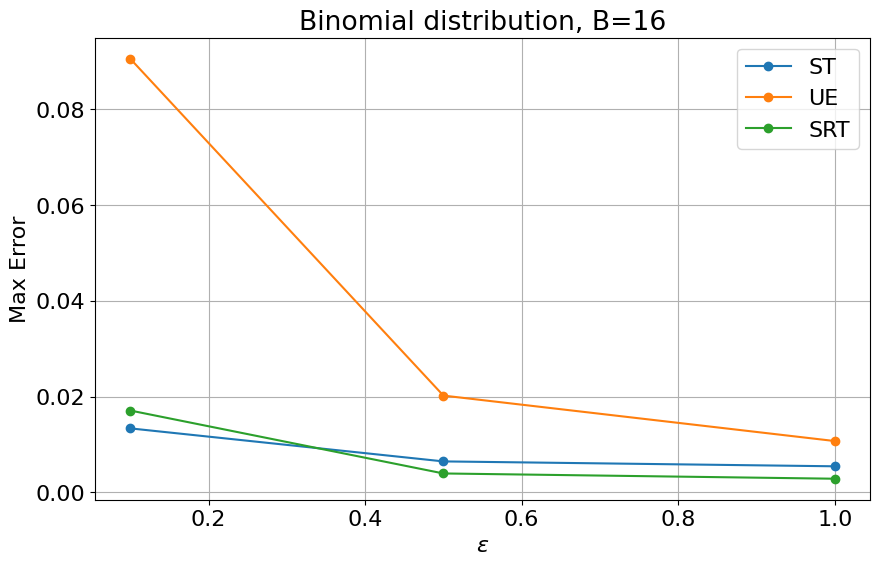

In [ ]:
plt.rcParams.update({'font.size': 16})

#Plotting maximum errors

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_max, '-o', label = "ST")
#plt.plot(Eps[:6], Err0_max, '-o', label = "ST")
#plt.plot(range(Trials), Err1_max, '-o', label = "SRT-v1")
plt.plot(Eps, Err1_max, '-o', label = "UE")
plt.plot(Eps, Err2_max, '-o', label = "SRT")
#plt.plot(Eps[:6], Err2_max, '-o', label = "SRT-v2")

plt.title(f"Binomial distribution, B=16")
plt.xlabel(f'$\epsilon$')
plt.ylabel('Max Error')
plt.grid(True)
plt.legend()
plt.show()

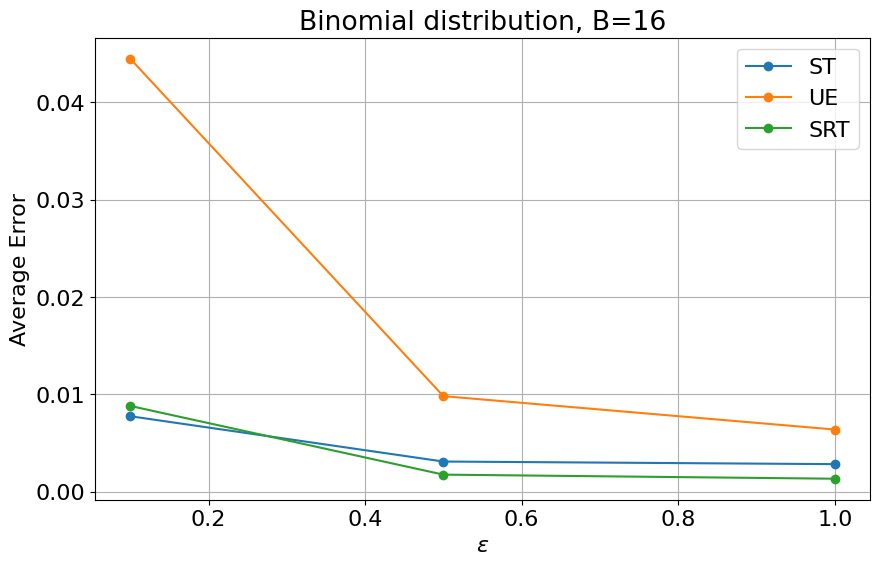

In [ ]:
#Plotting average errors

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_avg, '-o', label = "ST")
plt.plot(Eps, Err1_avg, '-o', label = "UE")
#plt.plot(range(Trials), Err1_avg, '-o', label = "SRT-v1")
plt.plot(Eps, Err2_avg, '-o', label = "SRT")

plt.title(f"Binomial distribution, B=16")
plt.xlabel(f'$\epsilon$')
plt.ylabel('Average Error')
plt.grid(True)
plt.legend()
plt.show()

## Graphing binomial distribution

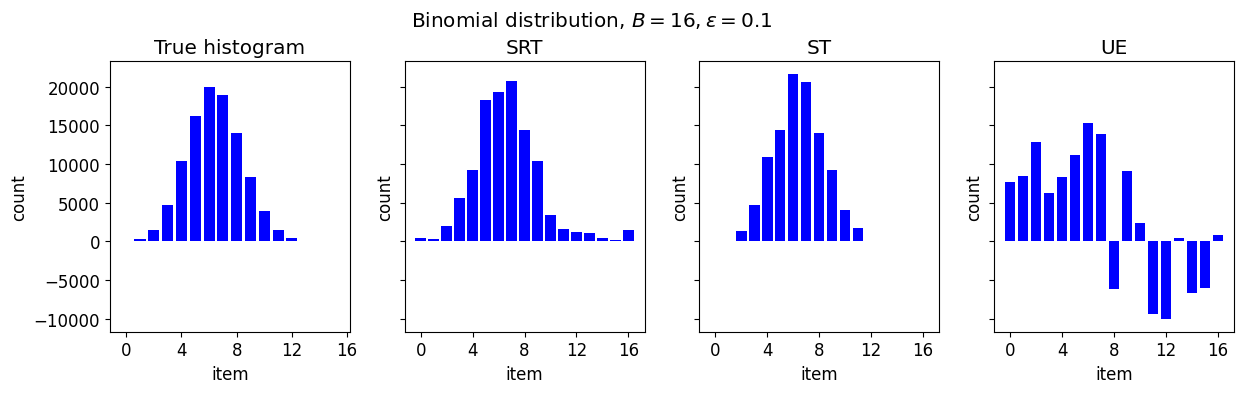

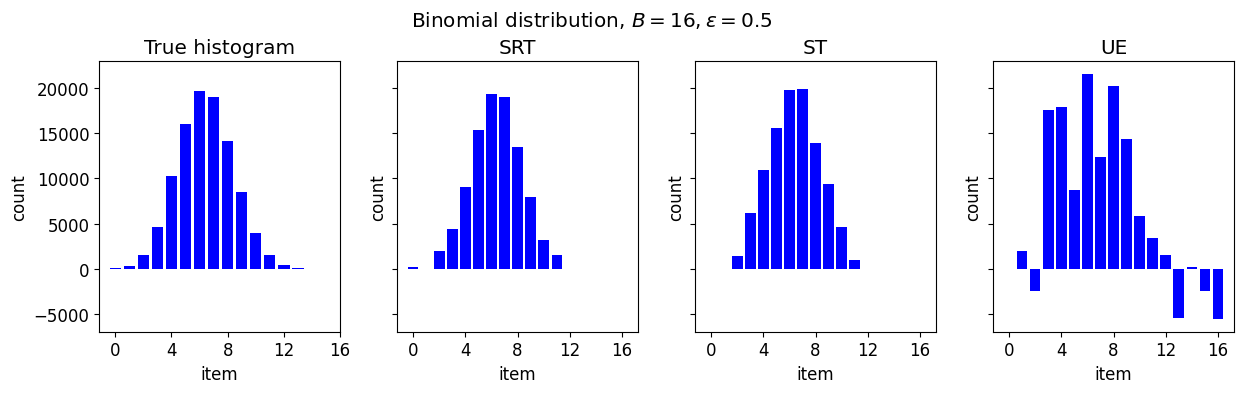

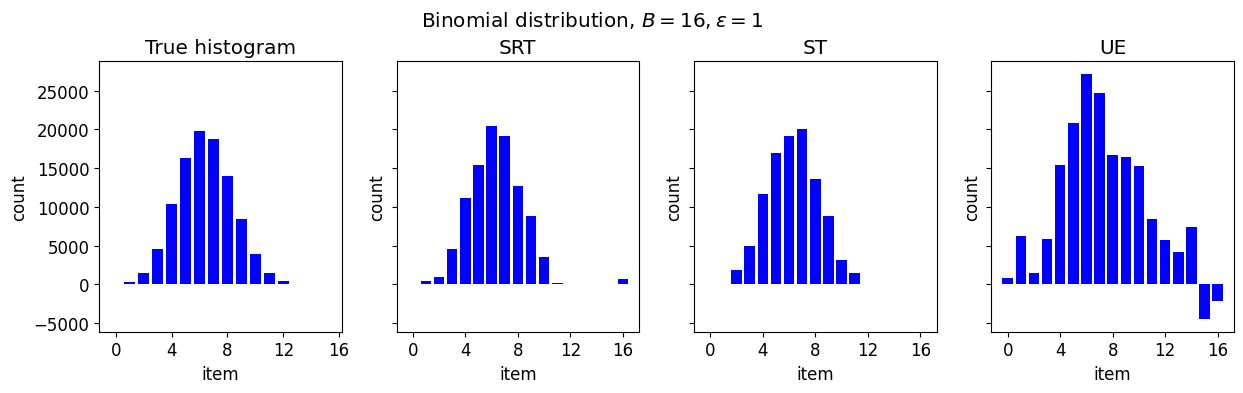

In [ ]:
#Checking dimension

import matplotlib.pyplot as plt


plt.rcParams.update({'font.size': 12})

B = 16

for i in [0, 1, 2]:
    cx0 = Dataset[i][0]
    calg0 = Dataset[i][1]
    calg1 = Dataset[i][2]
    calg2 = Dataset[i][3]

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12, 4))
    f.suptitle(f"Binomial distribution, $B = {B}, \epsilon = {Eps[i]}$")
    stepsize = max(1, len(calg0) // 4)

    ax1.bar(cx0.keys(), cx0.values(),  color='b')
    ax1.set_title("True histogram")
    ax1.set_xticks(range(0, len(calg0), stepsize))
    ax1.set_xlabel("item")
    ax1.set_ylabel("count")

    ax3.bar(range(len(calg0)), calg0,  color='b')
    ax3.set_title(r"ST")
    ax3.set_xticks(range(0, len(calg0), stepsize))
    ax3.set_xlabel("item")
    ax3.set_ylabel("count")

    ax4.bar(range(len(calg1)), calg1,  color='b')
    ax4.set_title(r"UE")
    ax4.set_xticks(range(0, len(calg0), stepsize))
    ax4.set_xlabel("item")
    ax4.set_ylabel("count")

    ax2.bar( range(len(calg2)), calg2,  color='b')
    ax2.set_title(r"SRT")
    ax2.set_xticks(range(0, len(calg0), stepsize))
    ax2.set_xlabel("item")
    ax2.set_ylabel("count")

    plt.tight_layout(rect=[0, 0, 1.05, 1.05])

### Calculating the error of full scale

In [ ]:
#Ploting the full scale

#define max errors
Err0_max = []
Err1_max = []
Err2_max = []

#define min errors
Err0_avg = []
Err1_avg = []
Err2_avg = []

for e in range(3):

  #define max errors
  Err0_max_temp = []
  Err1_max_temp = []
  Err2_max_temp = []

  #define min errors
  Err0_avg_temp = []
  Err1_avg_temp = []
  Err2_avg_temp = []

  for trials in range(Trials):
      cx0 = Dataset[e*10+trials][0]
      calg0 = Dataset[e*10+trials][1]
      calg1 = Dataset[e*10+trials][2]
      calg2 = Dataset[e*10+trials][3]

      #Measuring errors
      err0 = []
      err1 = []
      err2 = []

      for entry in range(len(calg0)):
          #entry = k_frequent[i][0]
          err0.append( abs( cx0[entry] - calg0[entry] ) / n )
          err1.append( abs( cx0[entry] - calg1[entry] ) / n )
          err2.append( abs( cx0[entry] - calg2[entry] ) / n )

      if len(err0) == 0:
          err0.append(0)
      if len(err1) == 0:
          err1.append(0)
      if len(err2) == 0:
          err2.append(0)

      Err0_max_temp.append(max(err0))
      Err1_max_temp.append(max(err1))
      Err2_max_temp.append(max(err2))

      Err0_avg_temp.append(mean(err0))
      Err1_avg_temp.append(mean(err1))
      Err2_avg_temp.append(mean(err2))

      #print("checkpoint: trials =  ", trials)

  Err0_max.append( mean(Err0_max_temp) )
  Err1_max.append( mean(Err1_max_temp) )
  Err2_max.append( mean(Err2_max_temp) )

  Err0_avg.append( mean(Err0_avg_temp) )
  Err1_avg.append( mean(Err1_avg_temp) )
  Err2_avg.append( mean(Err2_avg_temp) )

In [ ]:
print("Err0_max = ", Err0_max)
print("Err1_max = ", Err1_max)
print("Err2_max = ", Err2_max)
print("Err0_avg = ", Err0_avg)
print("Err1_avg = ", Err1_avg)
print("Err2_avg = ", Err2_avg)

Err0_max =  [0.017020999999999998, 0.015396749999999997, 0.012511]
Err1_max =  [0.13659675, 0.1095555, 0.08401725]
Err2_max =  [0.01055975, 0.008452999999999999, 0.006505749999999999]
Err0_avg =  [0.004023985294117647, 0.003490779411764706, 0.002928691176470588]
Err1_avg =  [0.051619573529411766, 0.03992686764705883, 0.029990147058823524]
Err2_avg =  [0.0033737499999999996, 0.0027836617647058826, 0.0021867794117647063]


In [ ]:
print(len(Dataset))

120


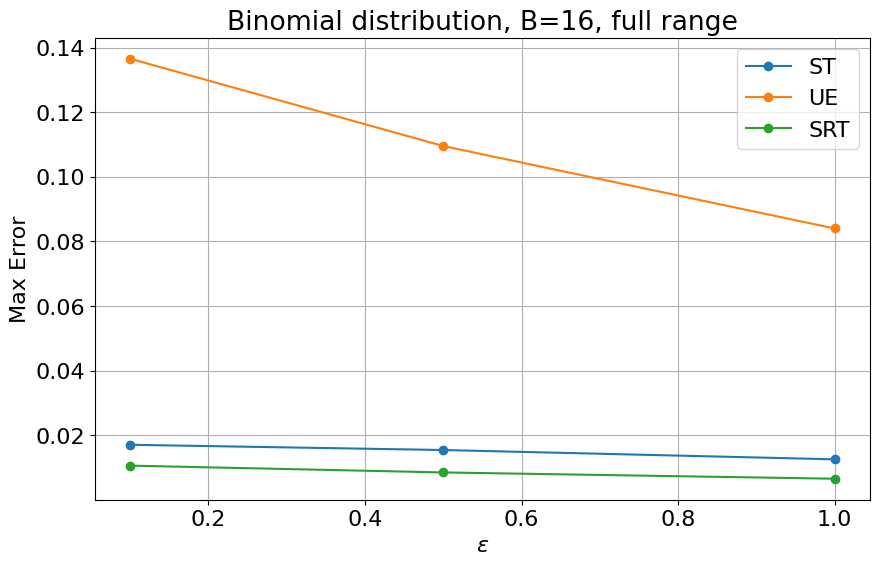

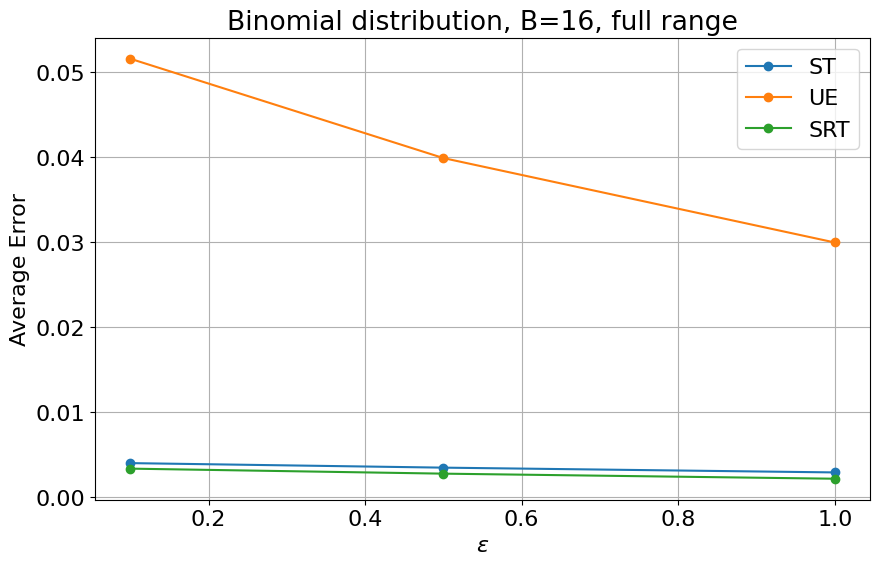

In [ ]:
#Plotting maximum errors

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_max, '-o', label = "ST")
#plt.plot(Eps[:6], Err0_max, '-o', label = "ST")
#plt.plot(range(Trials), Err1_max, '-o', label = "SRT-v1")
plt.plot(Eps, Err1_max, '-o', label = "UE")
plt.plot(Eps, Err2_max, '-o', label = "SRT")
#plt.plot(Eps[:6], Err2_max, '-o', label = "SRT-v2")

plt.title(f"Binomial distribution, B=16, full range")
plt.xlabel(f'$ \epsilon $')
plt.ylabel('Max Error')
plt.grid(True)
plt.legend()
plt.show()

#Plotting average errors

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_avg, '-o', label = "ST")
plt.plot(Eps, Err1_avg, '-o', label = "UE")
#plt.plot(range(Trials), Err1_avg, '-o', label = "SRT")
plt.plot(Eps, Err2_avg, '-o', label = "SRT")

plt.title(f"Binomial distribution, B=16, full range")
plt.xlabel(f'$\epsilon$')
plt.ylabel('Average Error')
plt.grid(True)
plt.legend()
plt.show()